This project attempts to implement a ML based approach towards forecasting GDP growth - as opposed to conventional, econometrics-based approaches.

Some caveats:
* Annual data is utilized, which might heavily decrease the accuracy; research has shown better results when using quarterly data
* Quarterly GDP growth is available in the OECD dataset, which would restrict the scope of countries
* Different data collection methodologies and standards of quality across governments might introduce extra bias in some observations and groups

This project is inspired by my MSc Statistics and Data Science thesis research; what you see here is part of the resulting work - in this notebook I am focusing exclusively on the development of supervised learning models

------------

Let us begin then:

In [1]:
#!pip install numpy==1.20.0 --user
#!pip install xgboost tensorflow keras plotly pycountry pycountry_convert jupyterthemes bioinfokit spicy bayesian-optimization pydot graphviz shap
#!pip install sklearn --upgrade --user
#!pip install --upgrade scipy.stats --user
#!conda install graphviz
#!pip install wbgapi

In [2]:
import pandas as pd
import numpy as np

import jupyterthemes

import pycountry, pycountry_convert
import wbgapi as wb
import requests
from scipy.interpolate import CubicSpline

import seaborn as sns

from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor


# gaussian mixture
from sklearn.mixture import GaussianMixture



# elastic net
from sklearn.model_selection import cross_val_score, RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import ElasticNet

# KNN regression
from sklearn.neighbors import KNeighborsRegressor, KernelDensity, KDTree

# XGBoost
import xgboost as xgb

# Neural Networks regression
from tensorflow.keras import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.layers import Dense, Dropout, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import tensorflow as tf
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
tf.compat.v1.disable_eager_execution()
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

# Walking window CV:
from sklearn.model_selection._split import TimeSeriesSplit
from sklearn.utils.validation import _deprecate_positional_args

from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples


import spicy
from math import sqrt, log, exp, floor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import cross_val_score
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error # for error reporting
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, OneClassSVM
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.pyplot import savefig
import statsmodels.api as sm
matplotlib.style.use('seaborn')

# World Bank data mining
We collect data from the WB using the Python package *wbgapi*, which makes accessing the API very simple

In [3]:
# for searching all indicators within a database
# wb.series.info(db=2)

In [4]:
# For searching specific indicators
wb.series.info(q='GDP')

id,value
EG.GDP.PUSE.KO.PP,GDP per unit of energy use (PPP $ per kg of oil equivalent)
EG.GDP.PUSE.KO.PP.KD,GDP per unit of energy use (constant 2017 PPP $ per kg of oil equivalent)
EG.USE.COMM.GD.PP.KD,"Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)"
NY.GDP.DEFL.KD.ZG,"Inflation, GDP deflator (annual %)"
NY.GDP.DEFL.KD.ZG.AD,"Inflation, GDP deflator: linked series (annual %)"
NY.GDP.DEFL.ZS,GDP deflator (base year varies by country)
NY.GDP.DEFL.ZS.AD,GDP deflator: linked series (base year varies by country)
NY.GDP.DISC.CN,Discrepancy in expenditure estimate of GDP (current LCU)
NY.GDP.DISC.KN,Discrepancy in expenditure estimate of GDP (constant LCU)
NY.GDP.MKTP.CD,GDP (current US$)


In [5]:
# collecting all keys and placing them into a nice dataframe - these are the labels of
# variables to be fed into the ML model, so it helps to be careful in this section:

vars_dict = {'code': ['NY.GDP.MKTP.KD.ZG', 'NY.GDP.MKTP.KD','NY.GDP.PCAP.KD',
                      'NE.CON.GOVT.ZS', 'NE.CON.PRVT.ZS', 'GC.NFN.TOTL.GD.ZS','NY.GDP.DEFL.KD.ZG', 'EG.FEC.RNEW.ZS',
                      'SL.UEM.TOTL.NE.ZS','SL.EMP.TOTL.SP.NE.ZS','HD.HCI.OVRL','SL.AGR.EMPL.ZS','SL.EMP.VULN.ZS',
                      # environment:
                      'EN.POP.SLUM.UR.ZS','ER.H2O.INTR.PC',
                      'NE.IMP.GNFS.ZS','NE.EXP.GNFS.ZS','BX.KLT.DINV.CD.WD','GC.DOD.TOTL.GD.ZS','FR.INR.RINR',
                      'SI.POV.DDAY','SI.POV.LMIC','SI.POV.UMIC','SI.POV.MDIM','SI.POV.MDIM.XQ',
                      'SI.POV.GINI','BN.CAB.XOKA.GD.ZS','SP.POP.TOTL','EN.POP.DNST','SP.POP.GROW',
                      'SP.DYN.LE00.IN','SP.DYN.CDRT.IN', 'SH.DYN.MORT','SH.DTH.COMM.ZS',
                      # agric:
                      'EG.ELC.RNEW.ZS','AG.LND.AGRI.ZS','NV.AGR.TOTL.ZS','AG.LND.ARBL.ZS','SP.RUR.TOTL.ZS',
                      # climate change:
                      'EG.ELC.ACCS.ZS','EG.USE.ELEC.KH.PC',
                      # energy & mining:
                      'TX.VAL.FUEL.ZS.UN','TX.VAL.MMTL.ZS.UN',
                      'EN.ATM.CO2E.PC','EN.CLC.GHGR.MT.CE','NV.IND.TOTL.ZS','NV.SRV.EMPL.KD',
                      'SE.ENR.PRSC.FM.ZS','SE.ADT.LITR.ZS','SE.TER.CUAT.BA.ZS','VC.IHR.PSRC.P5','SP.POP.SCIE.RD.P6'],
            'label': ['gdp_real_gwt', 'gdp_real_us_fixed','gdp_per_capita',
                      'gdp_pp_govt', 'gdp_pp_private', 'investment', 'inflation_pp', 'renew_energy',
                      'unemployment','employment','HCI','agric_employment','vulnerable_employment',
                      # environment:
                      'pop_slums','renew_freshwater',
                      'imports','exports','foreign_inv','govt_debt','real_interest_rate',
                      'poverty_1.90','poverty_3.20','poverty_5.50','poverty_multidim','poverty_mult_index',
                      'gini_index','cab','population','pop_density','pop_growth',
                      'life_expectancy','death_rate', 'child_mortality','cause_of_death',
                      # agric:
                      'renewable_energy_output','agric_land','agff_gdp','arable_land','rural_pop',
                      # climate change:
                      'electricity_access','power_consumption',
                      # energy & mining:
                      'fuel_exports','metal_exports',
                      'co2_emissions','ghg_emissions','industry_gdp','service_value_added',
                      'school_enroll','literacy','bachelor','homicide','research']}

vars_df = pd.DataFrame(vars_dict)

In [6]:
len(vars_df)

52

In [7]:
# obtaining definition/description of each variable
vars_df = vars_df.assign(definition='')
for i in range(0,len(vars_df)):
    vars_df.iloc[i,2] = wb.series.get(id=vars_df.iloc[i,0])['value']

In [8]:
vars_df

,code,label,definition
0,NY.GDP.MKTP.KD.ZG,gdp_real_gwt,GDP growth (annual %)
1,NY.GDP.MKTP.KD,gdp_real_us_fixed,GDP (constant 2015 US$)
2,NY.GDP.PCAP.KD,gdp_per_capita,GDP per capita (constant 2015 US$)
3,NE.CON.GOVT.ZS,gdp_pp_govt,General government final consumption expenditu...
4,NE.CON.PRVT.ZS,gdp_pp_private,Households and NPISHs final consumption expend...
5,GC.NFN.TOTL.GD.ZS,investment,Net investment in nonfinancial assets (% of GDP)
6,NY.GDP.DEFL.KD.ZG,inflation_pp,"Inflation, GDP deflator (annual %)"
7,EG.FEC.RNEW.ZS,renew_energy,Renewable energy consumption (% of total final...
8,SL.UEM.TOTL.NE.ZS,unemployment,"Unemployment, total (% of total labor force) (..."
9,SL.EMP.TOTL.SP.NE.ZS,employment,"Employment to population ratio, 15+, total (%)..."


In [9]:
# function for obtaining a clean dataframe with columns "economy", "Year", and economic indicators:
def vert_df(gdp_df, name):
    gdp_df.columns = gdp_df.columns.str.replace('YR','')
    gdp_df = gdp_df.reset_index()
    gdp_df.drop('Country', inplace=True, axis=1) # dropping "Country" - we are using the ISO3 code instead
    year_drop = list(range(1960, 1990)) # dropping all years before 1990
    year_drop = [str(e) for e in year_drop]
    gdp_df.drop(year_drop, inplace=True, axis=1)
    gdp_df = gdp_df.melt(id_vars = ['economy'], var_name = 'Year', value_name = name)
    gdp_df.Year = pd.to_numeric(gdp_df.Year)
    return gdp_df

In [11]:
# loop for creating dataframe to export:

gdp_df = vert_df(wb.data.DataFrame(vars_df.iloc[0,0], labels=True), vars_df.iloc[0,1])
for i in range(1, len(vars_df)):
    wbcode = vars_df.iloc[i,0]
    wblabel = vars_df.iloc[i,1]
    new_data = vert_df(wb.data.DataFrame(wbcode, labels=True), wblabel)
    gdp_df = pd.merge(gdp_df, new_data, how='left', on=['economy', 'Year'])

In [12]:
# replacing label:
gdp_df.rename(columns = {'economy':'ISO3'}, inplace = True)

In [13]:
gdp_df

,ISO3,Year,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,investment,inflation_pp,renew_energy,...,metal_exports,co2_emissions,ghg_emissions,industry_gdp,service_value_added,school_enroll,literacy,bachelor,homicide,research
0,ZWE,1990,6.988553,1.694150e+10,1623.930176,19.446133,63.105986,NaN,-0.920431,63.976409,...,15.910397,1.585444,NaN,29.803667,NaN,0.97075,NaN,NaN,5.626697,NaN
1,ZMB,1990,-0.481072,6.840844e+09,851.184841,NaN,NaN,NaN,106.388920,82.982734,...,NaN,0.340930,NaN,45.294071,NaN,NaN,64.998283,NaN,6.843478,NaN
2,YEM,1990,NaN,2.391779e+10,2042.512182,NaN,NaN,NaN,NaN,2.148638,...,NaN,0.567037,NaN,34.343661,NaN,NaN,NaN,NaN,NaN,NaN
3,PSE,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.082083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VIR,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,CEB,2021,5.564249,1.544115e+12,15187.580223,19.434876,55.023021,NaN,5.451522,NaN,...,2.752761,NaN,NaN,27.953207,NaN,NaN,NaN,NaN,NaN,NaN
8508,CSS,2021,5.154339,7.101314e+10,9491.666242,NaN,NaN,NaN,1.983975,NaN,...,0.989368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8509,ARB,2021,3.530294,2.689385e+12,6050.118638,18.310636,NaN,NaN,8.990940,NaN,...,NaN,NaN,NaN,43.144994,NaN,NaN,NaN,NaN,NaN,NaN
8510,AFW,2021,3.914799,8.527638e+11,1810.927774,8.339461,63.593360,NaN,4.821155,NaN,...,NaN,NaN,NaN,29.163412,NaN,NaN,NaN,NaN,NaN,NaN


# ML forecasting
The goal is to forecast the next period's GDP growth (in real 2015 US dollars), therefore all explanatory variables are lagged by one period (one year)

GDP growth two-year lagged is also included to account for any potential autorregresive aspects

## Building the dataset:

In [14]:
full_countries_list = gdp_df.ISO3.unique()
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita',
       'gdp_pp_govt', 'gdp_pp_private', 'investment', 'inflation_pp',
       'renew_energy', 'unemployment', 'employment', 'HCI', 'agric_employment',
       'vulnerable_employment', 'pop_slums', 'renew_freshwater', 'imports',
       'exports', 'foreign_inv', 'govt_debt', 'real_interest_rate',
       'poverty_1.90', 'poverty_3.20', 'poverty_5.50', 'poverty_multidim',
       'poverty_mult_index', 'gini_index', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'cause_of_death', 'renewable_energy_output', 'agric_land', 'agff_gdp',
       'arable_land', 'rural_pop', 'electricity_access', 'power_consumption',
       'fuel_exports', 'metal_exports', 'co2_emissions', 'ghg_emissions',
       'industry_gdp', 'service_value_added', 'school_enroll', 'literacy',
       'bachelor', 'homicide', 'research'],
      dtype='object')

In [15]:
df_mv = gdp_df.iloc[:,1:(gdp_df.shape[1]-3)]
# amount of NaN:
df_mv.groupby('Year').apply(lambda x: x.isnull().sum()).iloc[:,1:].sum().sum()/(df_mv.iloc[:,1:].shape[0]*df_mv.iloc[:,1:].shape[1])

0.3804496892742059

In [16]:
# modify here to change years:
start_year = 2009
end_year = 2018

In [17]:
# lagging variables:

gdp_df.insert(2, 'gdp_real_gwt_prev', gdp_df.groupby(by="ISO3").shift(1)['gdp_real_gwt'], 'gdp_real_gwt_prev')
gdp_df.insert(2, 'gdp_real_gwt_next', gdp_df.groupby(by="ISO3").shift(-1)['gdp_real_gwt'], 'gdp_real_gwt_next')
gdp_df.insert(2, 'pop_growth_next', gdp_df.groupby(by="ISO3").shift(-1)['pop_growth'], 'pop_growth_next')

# selecting years:

gdp_df = gdp_df[gdp_df['Year']>=start_year]
gdp_df = gdp_df[gdp_df['Year']<=end_year]

# removing all countries with missing data in key variables (GDP, essential data like CAB and private/public expenditure):

gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt_next'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt_prev'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_pp_govt'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_pp_private'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['cab'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]

remaining_countries_list = gdp_df.ISO3.unique()

In [18]:
# checking which countries have been filtered out
removed_countries_list = list(set(full_countries_list) - set(remaining_countries_list))
print('Filtered countries: '+ str(len(removed_countries_list)))
print('Remaining countries: '+str(len(remaining_countries_list)))

Filtered countries: 104
Remaining countries: 162


In [19]:
for iso in removed_countries_list:
    try:
        print(iso + ' | ' + pycountry.countries.get(alpha_3=iso).name)
    except:
        print(iso + ' | ' + '------------ NONE ------------')
        
# all countries with "NONE" printed have no recognized ISO3 code - often they are groups of countries, non-recognized nations, etcetera

LTE | ------------ NONE ------------
ECS | ------------ NONE ------------
OED | ------------ NONE ------------
LCN | ------------ NONE ------------
PSS | ------------ NONE ------------
SST | ------------ NONE ------------
GUM | Guam
MWI | Malawi
TLA | ------------ NONE ------------
NRU | Nauru
ASM | American Samoa
LCA | Saint Lucia
PRE | ------------ NONE ------------
SAS | ------------ NONE ------------
OSS | ------------ NONE ------------
LIC | ------------ NONE ------------
CYM | Cayman Islands
CAF | Central African Republic
CEB | ------------ NONE ------------
SOM | Somalia
EUU | ------------ NONE ------------
VEN | Venezuela, Bolivarian Republic of
AFG | Afghanistan
IDB | ------------ NONE ------------
SSD | South Sudan
VGB | Virgin Islands, British
TEC | ------------ NONE ------------
TKM | Turkmenistan
GIB | Gibraltar
TMN | ------------ NONE ------------
FCS | ------------ NONE ------------
PYF | French Polynesia
ERI | Eritrea
IBT | ------------ NONE ------------
EAS | ---------

--------------------------------------
#### Benchmark for models

For assessing the performance of ML models, we need a benchmark; in this case, we select the next-year forecasts of the World Economic Outlook, from the International Monetary Fund

This forecast is produced twice a year - in fall and in spring

Source: https://www.imf.org/external/pubs/ft/weo/data/WEOhistorical.xlsx </br>
Extra material: https://www.elibrary.imf.org/view/journals/001/2021/216/article-A001-en.xml

Hence, we create a dataframe with all forecasts, assess the errors (MAE and MSE), and filter all countries that have missing values in forecasts

In [20]:
# discarding countries without a WEO forecast for the selected years:
gdp_df_copy = gdp_df.copy()

url = 'https://www.imf.org/external/pubs/ft/weo/data/WEOhistorical.xlsx'
weo_excel = pd.ExcelFile(url)
weo_excel.sheet_names
df_weo = pd.read_excel(url, sheet_name="ngdp_rpch")
s_weo = df_weo[df_weo.columns[(~df_weo.columns.str.startswith('F'))]]
f_weo = df_weo[df_weo.columns[(~df_weo.columns.str.startswith('S'))]]
df_weo_melt = df_weo.melt(id_vars=['country','WEO_Country_Code','ISOAlpha_3Code','year'], 
                          var_name="year_report",
                          value_name="gdp_pc_weo").dropna()
df_weo_melt = df_weo_melt[df_weo_melt.gdp_pc_weo!='.']
## obtaining one-year forecasts for each report:
weo_forecast_1S = df_weo_melt[(df_weo_melt.year_report.str.startswith('S')) & 
                              (df_weo_melt.year == df_weo_melt.year_report.str[1:5].astype('int') + 1)]
weo_forecast_1S.loc[:,'year_report'] = weo_forecast_1S.loc[:,'year'] - 1
weo_forecast_1S = weo_forecast_1S[(weo_forecast_1S.year_report >= start_year) & (weo_forecast_1S.year_report <= end_year)]
weo_forecast_1F = df_weo_melt[(df_weo_melt.year_report.str.startswith('F')) & 
                              (df_weo_melt.year == df_weo_melt.year_report.str[1:5].astype('int') + 1)]
weo_forecast_1F.loc[:,'year_report'] = weo_forecast_1F.loc[:,'year'] - 1
weo_forecast_1F = weo_forecast_1F[(weo_forecast_1F.year_report >= start_year) & (weo_forecast_1F.year_report <= end_year)]

merge_fc_1S = pd.merge(gdp_df_copy, weo_forecast_1S, how='left', left_on=['ISO3','Year'], right_on=['ISOAlpha_3Code','year_report'])
merge_fc_1F = pd.merge(gdp_df_copy, weo_forecast_1F, how='left', left_on=['ISO3','Year'], right_on=['ISOAlpha_3Code','year_report'])

nan_weo_forecast = merge_fc_1S[merge_fc_1S.gdp_pc_weo.isna()].ISO3.unique()
nan_weo_forecast = np.unique(np.concatenate([nan_weo_forecast, merge_fc_1F[merge_fc_1F.gdp_pc_weo.isna()].ISO3.unique()]))

nan_weo_forecast # prints the countries that have missing values in forecasts

array(['ABW', 'BMU', 'CUW', 'CYP', 'LBY', 'MAC', 'MHL', 'PSE', 'UKR',
       'ZWE'], dtype=object)

In [21]:
# removing such countries from all dataframes

for nan_country in nan_weo_forecast.tolist():
    gdp_df = gdp_df[gdp_df.ISO3 != nan_country]
    merge_fc_1S = merge_fc_1S[merge_fc_1S.ISO3 != nan_country]
    merge_fc_1F = merge_fc_1F[merge_fc_1F.ISO3 != nan_country]

In [22]:
try:
    gdp_graph_df = gdp_df.copy()
    gdp_df = gdp_df.drop(columns=['pop_growth_next'], inplace=False)
except:
    pass

In [23]:
len(gdp_df)

1520

In [24]:
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'investment', 'inflation_pp', 'renew_energy',
       'unemployment', 'employment', 'HCI', 'agric_employment',
       'vulnerable_employment', 'pop_slums', 'renew_freshwater', 'imports',
       'exports', 'foreign_inv', 'govt_debt', 'real_interest_rate',
       'poverty_1.90', 'poverty_3.20', 'poverty_5.50', 'poverty_multidim',
       'poverty_mult_index', 'gini_index', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'cause_of_death', 'renewable_energy_output', 'agric_land', 'agff_gdp',
       'arable_land', 'rural_pop', 'electricity_access', 'power_consumption',
       'fuel_exports', 'metal_exports', 'co2_emissions', 'ghg_emissions',
       'industry_gdp', 'service_value_added', 'school_enroll', 'literacy',
       'bachelor', 'homicide', 'research'],
   

#### Cleaning data (continued):
We remove columns with over 30% of missing values

In [25]:
# dropping all variables with >30% missing values (arbitrary value)

cols_i = gdp_df.shape[1]
gdp_df_columns1 = gdp_df.columns
gdp_df = gdp_df.dropna(thresh=len(gdp_df)*0.7, axis='columns')
cols_f = gdp_df.shape[1]
gdp_df_copy = gdp_df.copy()
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'renew_energy', 'unemployment',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added', 'homicide'],
      dtype='object')

In [26]:
# removed variables:
list(set(gdp_df.columns.tolist())^set(gdp_df_columns1.tolist()))

['employment',
 'poverty_multidim',
 'poverty_5.50',
 'poverty_3.20',
 'investment',
 'renew_freshwater',
 'HCI',
 'pop_slums',
 'gini_index',
 'cause_of_death',
 'literacy',
 'poverty_mult_index',
 'power_consumption',
 'school_enroll',
 'bachelor',
 'ghg_emissions',
 'research',
 'govt_debt',
 'poverty_1.90']

In [27]:
print('Removed columns: '+str(cols_i - cols_f))

Removed columns: 19


In [28]:
gdp_df.shape

(1520, 37)

In [29]:
# observations for a random country (Argentina)
pd.set_option("display.max_columns", None)
gdp_df[gdp_df['ISO3']=='ARG']

,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,inflation_pp,renew_energy,unemployment,agric_employment,vulnerable_employment,imports,exports,foreign_inv,real_interest_rate,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added,homicide
5263,ARG,2009,10.125398,4.057233,-5.918525,5.019171e+11,12398.283581,15.903897,62.978148,15.377649,8.59,8.65,1.23,19.590001,14.496142,19.560985,4.017159e+09,NaN,2.178567,40482786.0,14.792609,0.999542,75.116,7.722,14.9,28.927403,45.430209,5.273623,12.603072,9.309,97.750656,10.165245,3.757182,3.867570,25.284205,22333.508982,6.526231
5529,ARG,2010,6.003952,-5.918525,10.125398,5.527382e+11,13551.339194,15.163718,64.234115,20.915124,8.79,7.71,1.27,19.050000,16.037190,18.933823,1.133272e+10,-8.566029,-0.383119,40788453.0,14.904302,0.752218,75.278,7.708,14.5,28.585456,46.138912,7.132167,13.886520,9.151,98.820000,7.903177,4.291375,4.099690,25.258776,23747.038809,5.829456
5795,ARG,2011,-1.026420,10.125398,6.003952,5.859243e+11,14200.269889,15.688957,64.220321,23.703472,8.83,7.18,0.64,18.620000,16.756946,18.449209,1.083993e+10,-7.773405,-1.007271,41261490.0,15.077152,1.153059,75.439,7.694,13.9,32.305970,45.791960,6.998734,14.114313,9.010,99.095352,5.972465,3.938766,4.280989,25.212698,24676.655360,6.076887
6061,ARG,2012,2.405324,6.003952,-1.026420,5.799102e+11,13895.633707,16.645438,64.903399,22.314881,8.61,7.22,0.62,19.030000,14.288683,16.237859,1.532393e+10,-6.748196,-0.391595,41733271.0,15.249543,1.136906,75.598,7.680,13.3,29.261135,45.581304,5.781744,14.478403,8.879,99.229980,6.228469,4.060739,4.264224,24.429057,24459.730816,6.341727
6327,ARG,2013,-2.512615,-1.026420,2.405324,5.938590e+11,14071.508683,16.806238,65.987566,23.948798,8.91,7.10,0.62,19.690000,14.716756,14.617173,9.821662e+09,-5.485839,-2.377496,42202935.0,15.421160,1.119109,75.756,7.665,12.7,31.484491,44.921931,6.052918,14.393775,8.751,99.342674,4.682108,3.178088,4.342115,24.005881,24776.527255,7.280305
6593,ARG,2014,2.731160,2.405324,-2.512615,5.789376e+11,13567.948416,16.949876,65.383080,40.282972,9.79,7.27,0.55,20.180000,14.001315,14.405479,5.065336e+09,-11.600699,-1.744002,42669500.0,15.591645,1.099461,75.913,7.651,12.1,31.576204,43.853305,6.712704,13.899894,8.623,100.000000,4.677990,3.264377,4.209096,24.277394,24361.666474,7.570799
6859,ARG,2015,-2.080328,-2.512615,2.731160,5.947493e+11,13789.060425,18.098380,65.905837,26.579992,9.40,NaN,0.26,20.430000,11.780574,10.705652,1.175899e+10,-1.314709,-2.962927,43131966.0,15.760633,1.078001,76.068,7.638,11.5,28.140069,42.784678,5.156686,13.406012,8.497,99.625389,2.538595,2.749316,4.301914,23.153056,24393.605481,6.586123
7125,ARG,2016,2.818503,2.731160,-2.080328,5.823766e+11,13360.211835,17.654578,65.721891,41.119380,9.38,NaN,0.13,21.120001,13.566793,12.527095,3.260164e+09,-7.006040,-2.709226,43590368.0,15.928135,1.057182,76.221,7.626,10.9,NaN,41.716051,6.264566,12.912131,8.373,99.849579,2.496268,3.214868,4.201846,22.054107,23782.042729,6.033310
7391,ARG,2017,-2.617396,-2.080328,2.818503,5.987909e+11,13595.037355,17.696894,66.739573,26.006379,10.37,8.35,0.06,21.510000,13.969318,11.320283,1.151686e+10,0.455893,-4.839957,44044811.0,16.094191,1.037134,76.372,7.616,10.3,NaN,40.647424,5.231622,12.418250,8.251,100.000000,2.785001,3.190258,4.071308,21.782123,23926.097754,5.273443
7657,ARG,2018,-2.025934,2.818503,-2.617396,5.831181e+11,13105.397163,15.805097,69.470182,42.033669,10.52,9.22,0.10,21.620000,16.325850,14.436686,1.171677e+10,4.564409,-5.160554,44494502.0,16.258510,1.015808,76.520,7.609,9.7,NaN,39.603229,4.537879,11.924171,8.130,99.989578,4.119374,0.475469,3.975772,23.719592,23247.149249,5.380834


In [30]:
# pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)

#### Calculating MAE and RMSE of WEO forecasts (benchmark referred to previously):
We come back to this later after anomaly detection

In [31]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def rmse_forecast_scaled(y_true, y_pred):
    scaler = StandardScaler()
    scaler.fit(np.asarray(y_true).reshape(-1,1))
    y_true = scaler.transform(np.asarray(y_true).reshape(-1,1))
    y_pred = scaler.transform(np.asarray(y_pred).reshape(-1,1))
    return sqrt(mean_squared_error(y_true, y_pred))

def mae_forecast_scaled(y_true, y_pred):
    scaler = StandardScaler()
    scaler.fit(np.asarray(y_true).reshape(-1,1))
    y_true = scaler.transform(np.asarray(y_true).reshape(-1,1))
    y_pred = scaler.transform(np.asarray(y_pred).reshape(-1,1))
    return mean_absolute_error(y_true, y_pred)

In [32]:
rmse_forecast_scaled(merge_fc_1S.gdp_real_gwt_next, merge_fc_1S.gdp_pc_weo)

0.9369638791595681

In [33]:
mae_forecast_scaled(merge_fc_1S.gdp_real_gwt_next, merge_fc_1S.gdp_pc_weo)

0.6165034182959694

In [34]:
rmse_forecast_scaled(merge_fc_1F.gdp_real_gwt_next, merge_fc_1F.gdp_pc_weo)

0.9086673698556579

In [35]:
mae_forecast_scaled(merge_fc_1F.gdp_real_gwt_next, merge_fc_1F.gdp_pc_weo)

0.563730018744756

Years 2011 onwards:

In [36]:
mae_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=2010].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=2010].gdp_pc_weo)

0.5934896670997875

In [37]:
rmse_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=2010].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=2010].gdp_pc_weo)

0.9299628272771832

In [38]:
mae_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=2010].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=2010].gdp_pc_weo)

0.5503925303835867

In [39]:
rmse_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=2010].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=2010].gdp_pc_weo)

0.9212936788796144

--------------------------
## Data exploration
We introduce here basic descriptive statistics </br>
For this purpose, we construct a set with the latest values available for each covariate, per country


This section is for exploratory purposes, and can be adjusted at will depending on the needs of the research project

### Panel data plots:

In [35]:
gdp_graph_df['gdp_growth_converted'] = ((gdp_graph_df.gdp_real_gwt_next + 100)/100)
gdp_graph_df['pop_growth_converted'] = ((gdp_graph_df.pop_growth_next + 100)/100)
gdp_graph_df['gdp_pc_growth'] = gdp_graph_df['gdp_growth_converted'] / gdp_graph_df['pop_growth_converted']

In [36]:
gdp_graph_df.gdp_growth_converted.max()

1.2517624519370099

In [37]:
((gdp_graph_df.gdp_real_gwt + 100)/100).max()

1.2517624519370099

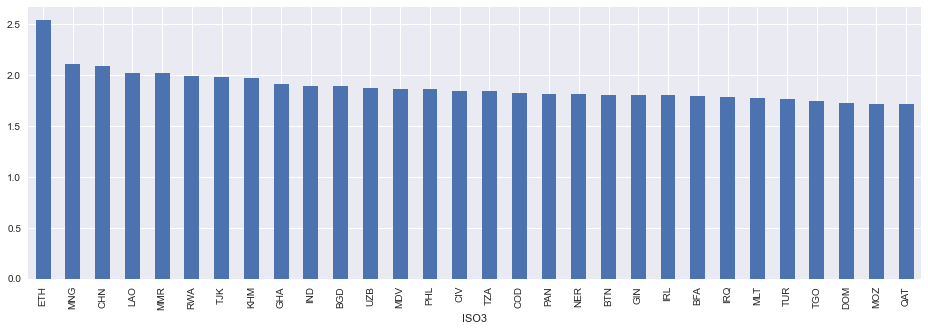

In [39]:
# accumulated GDP growth for the selected years, highest 30

gwt_pivot = gdp_graph_df.pivot_table(values='gdp_growth_converted',
                                index='Year',
                                columns=['ISO3'])
gwt_pivot.index = pd.to_datetime(gwt_pivot.index, format='%Y')
plt.rcParams["figure.figsize"] = (16, 5)
gwt_pivot.prod().sort_values(ascending=False)[:30].plot(kind='bar')#, title="Countries with highest GDP growth, 2003 - 2019")

In [40]:
maxc = 20
for i in range(maxc):
    country = gwt_pivot.prod().sort_values(ascending=False).index[i]
    gwt = gwt_pivot.prod().sort_values(ascending=False).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 2.540 | Ethiopia
02 | 2.108 | Mongolia
03 | 2.094 | China
04 | 2.025 | Lao People's Democratic Republic
05 | 2.017 | Myanmar
06 | 1.995 | Rwanda
07 | 1.976 | Tajikistan
08 | 1.972 | Cambodia
09 | 1.917 | Ghana
10 | 1.897 | India
11 | 1.896 | Bangladesh
12 | 1.876 | Uzbekistan
13 | 1.863 | Maldives
14 | 1.860 | Philippines
15 | 1.846 | Côte d'Ivoire
16 | 1.843 | Tanzania, United Republic of
17 | 1.826 | Congo, The Democratic Republic of the
18 | 1.817 | Panama
19 | 1.817 | Niger
20 | 1.805 | Bhutan


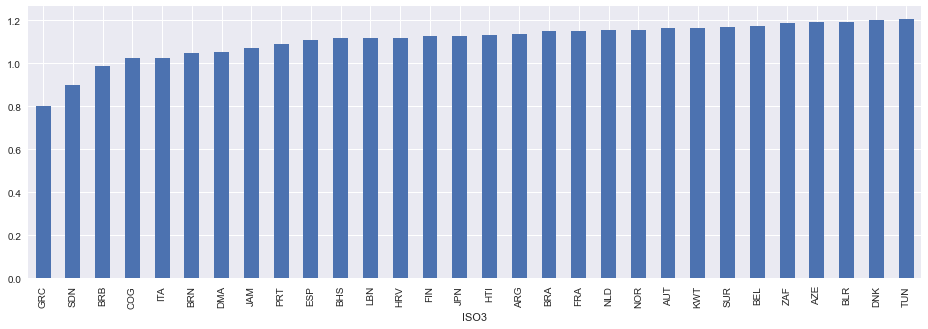

In [42]:
# accumulated GDP growth for the selected years, lowest 30

gwt_pivot.prod().sort_values(ascending=True)[:30].plot(kind='bar')#, title="Countries with lowest GDP growth, 2003 - 2019")

In [41]:
maxc = 20
for i in range(maxc):
    country = gwt_pivot.prod().sort_values(ascending=True).index[i]
    gwt = gwt_pivot.prod().sort_values(ascending=True).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 0.803 | Greece
02 | 0.900 | Sudan
03 | 0.987 | Barbados
04 | 1.024 | Congo
05 | 1.027 | Italy
06 | 1.048 | Brunei Darussalam
07 | 1.051 | Dominica
08 | 1.071 | Jamaica
09 | 1.088 | Portugal
10 | 1.108 | Spain
11 | 1.116 | Bahamas
12 | 1.118 | Lebanon
13 | 1.119 | Croatia
14 | 1.125 | Finland
15 | 1.127 | Japan
16 | 1.132 | Haiti
17 | 1.138 | Argentina
18 | 1.149 | Brazil
19 | 1.151 | France
20 | 1.155 | Netherlands


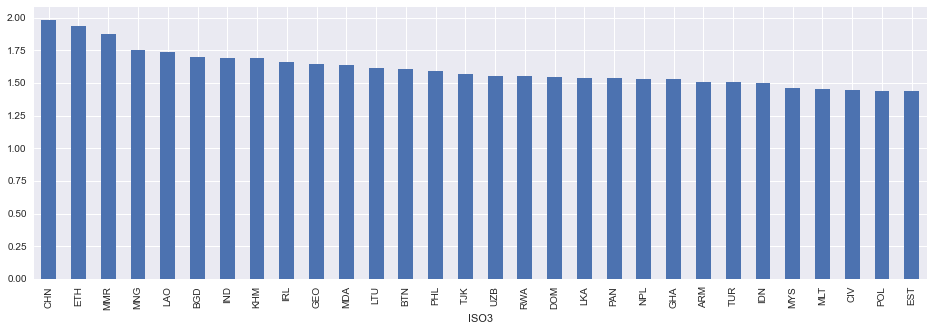

In [43]:
# same as above, but per capita

gwt_pc_pivot = gdp_graph_df.pivot_table(values='gdp_pc_growth',
                                index='Year',
                                columns=['ISO3'])
gwt_pc_pivot.index = pd.to_datetime(gwt_pivot.index, format='%Y')
plt.rcParams["figure.figsize"] = (16, 5)
gwt_pc_pivot.prod().sort_values(ascending=False)[:30].plot(kind='bar')#, title="Countries with highest GDP per capita growth, 2003 - 2019")

In [46]:
maxc = 20
for i in range(maxc):
    country = gwt_pc_pivot.prod().sort_values(ascending=False).index[i]
    gwt = gwt_pc_pivot.prod().sort_values(ascending=False).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 1.980 | China
02 | 1.938 | Ethiopia
03 | 1.876 | Myanmar
04 | 1.751 | Mongolia
05 | 1.738 | Lao People's Democratic Republic
06 | 1.698 | Bangladesh
07 | 1.692 | India
08 | 1.688 | Cambodia
09 | 1.656 | Ireland
10 | 1.648 | Georgia
11 | 1.634 | Moldova, Republic of
12 | 1.613 | Lithuania
13 | 1.606 | Bhutan
14 | 1.592 | Philippines
15 | 1.566 | Tajikistan
16 | 1.554 | Uzbekistan
17 | 1.551 | Rwanda
18 | 1.543 | Dominican Republic
19 | 1.538 | Sri Lanka
20 | 1.534 | Panama


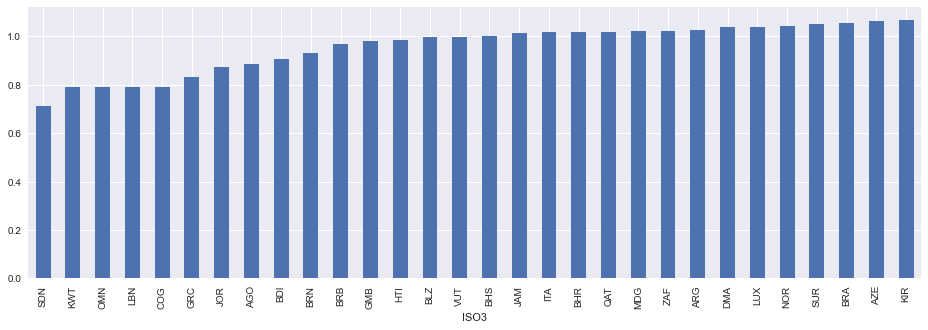

In [45]:
gwt_pc_pivot.prod().sort_values(ascending=True)[:30].plot(kind='bar')#, title="Countries with lowest GDP per capita growth, 2003 - 2019")

In [47]:
maxc = 20
for i in range(maxc):
    country = gwt_pc_pivot.prod().sort_values(ascending=True).index[i]
    gwt = gwt_pc_pivot.prod().sort_values(ascending=True).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 0.712 | Sudan
02 | 0.789 | Kuwait
03 | 0.790 | Oman
04 | 0.791 | Lebanon
05 | 0.792 | Congo
06 | 0.832 | Greece
07 | 0.872 | Jordan
08 | 0.887 | Angola
09 | 0.908 | Burundi
10 | 0.930 | Brunei Darussalam
11 | 0.967 | Barbados
12 | 0.979 | Gambia
13 | 0.985 | Haiti
14 | 0.999 | Belize
15 | 0.999 | Vanuatu
16 | 1.002 | Bahamas
17 | 1.016 | Jamaica
18 | 1.016 | Italy
19 | 1.018 | Bahrain
20 | 1.019 | Qatar


#### Dataframe for the following plots:

In [48]:
gdp_growth_total = ((gdp_df.gdp_real_gwt + 100)/100)
gdp_growth_total = pd.DataFrame({'ISO3': gdp_df['ISO3'], 'gdp_growth_total': gdp_growth_total})
gdp_growth_total = gdp_growth_total.groupby('ISO3', as_index=False).prod().gdp_growth_total

pop_growth_total = ((gdp_df.pop_growth + 100)/100)
pop_growth_total = pd.DataFrame({'ISO3': gdp_df['ISO3'], 'pop_growth_total': pop_growth_total})
pop_growth_total = pop_growth_total.groupby('ISO3', as_index=False).prod().pop_growth_total

In [49]:
gdp_unsupervised = gdp_df.groupby('ISO3', as_index=False).last()
gdp_unsupervised['gdp_per_capita'] = gdp_unsupervised.gdp_real_us_fixed / gdp_unsupervised.population
gdp_unsupervised['log_gdp_per_capita'] = np.log(gdp_unsupervised.gdp_per_capita)
gdp_unsupervised['gdp_growth_total'] = gdp_growth_total
gdp_unsupervised['pop_growth_total'] = pop_growth_total
gdp_unsupervised['gdp_pc_growth_total'] = gdp_growth_total / pop_growth_total
gdp_unsupervised['log_co2_emissions'] = np.log(gdp_unsupervised['co2_emissions'])
gdp_unsupervised.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'renew_energy', 'unemployment',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added', 'homicide',
       'log_gdp_per_capita', 'gdp_growth_total', 'pop_growth_total',
       'gdp_pc_growth_total', 'log_co2_emissions'],
      dtype='object')

In [38]:
# creating classifications for income groups - provided by the World Bank:

url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications

,Economy,Code,Region,Income group,Lending category,Other (EMU or HIPC)
0,Aruba,ABW,Latin America & Caribbean,High income,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN
...,...,...,...,...,...,...
260,Sub-Saharan Africa,SSF,NaN,NaN,NaN,NaN
261,Sub-Saharan Africa (excluding high income),SSA,NaN,NaN,NaN,NaN
262,Sub-Saharan Africa (IDA & IBRD),TSS,NaN,NaN,NaN,NaN
263,Upper middle income,UMC,NaN,NaN,NaN,NaN


In [39]:
classifications = classifications[['Code', 'Income group']]
classifications.columns = classifications.columns.str.replace('Code', 'ISO3')

In [54]:
gdp_unsupervised = gdp_unsupervised.merge(classifications[['ISO3','Income group']], how='left')
# gdp_unsupervised.columns = gdp_unsupervised.columns.str.replace('Income group', 'income_group')

In [55]:
gdp_unsupervised = gdp_unsupervised.drop(['Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev', 'gdp_real_gwt',#'renewable_energy_consumption',
       'service_value_added','gdp_per_capita'], axis=1)
gdp_unsupervised.columns

Index(['ISO3', 'gdp_real_us_fixed', 'gdp_pp_govt', 'gdp_pp_private',
       'inflation_pp', 'renew_energy', 'unemployment', 'agric_employment',
       'vulnerable_employment', 'imports', 'exports', 'foreign_inv',
       'real_interest_rate', 'cab', 'population', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'homicide', 'log_gdp_per_capita',
       'gdp_growth_total', 'pop_growth_total', 'gdp_pc_growth_total',
       'log_co2_emissions', 'Income group'],
      dtype='object')

In [56]:
gdp_unsupervised['Income group'].value_counts()

High income            51
Lower middle income    43
Upper middle income    41
Low income             17
Name: Income group, dtype: int64

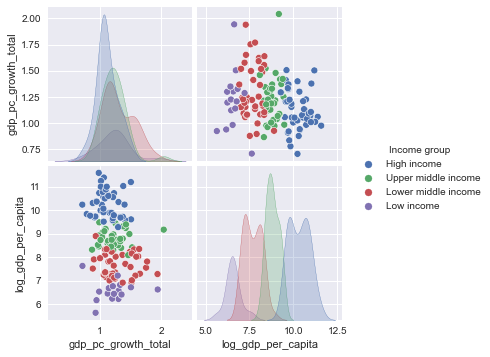

In [57]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_unsupervised[['gdp_pc_growth_total','log_gdp_per_capita','Income group'#'inflation_pp',
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order)

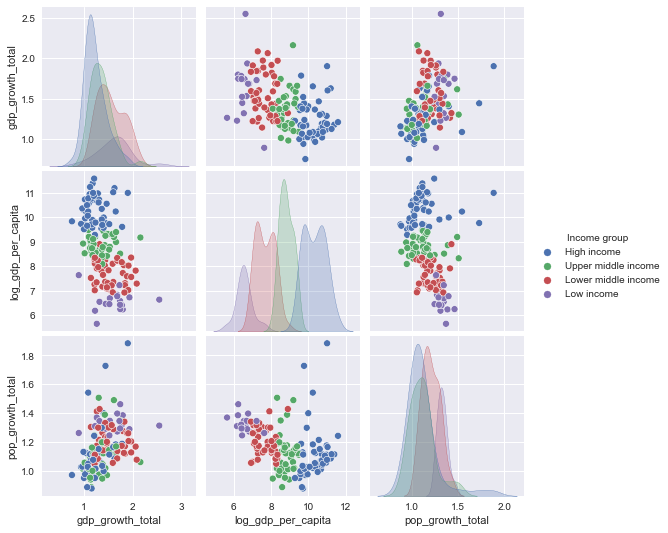

In [58]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_unsupervised[['gdp_growth_total','log_gdp_per_capita','pop_growth_total','Income group'#'inflation_pp',
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order)

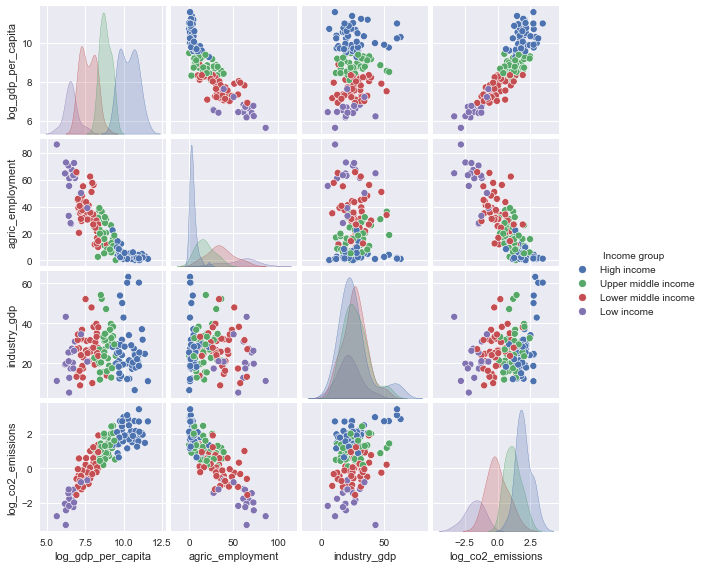

In [59]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_unsupervised[['log_gdp_per_capita', 'Income group',#'inflation_pp',
                               'agric_employment',
                               'industry_gdp','log_co2_emissions'
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order, size=2)

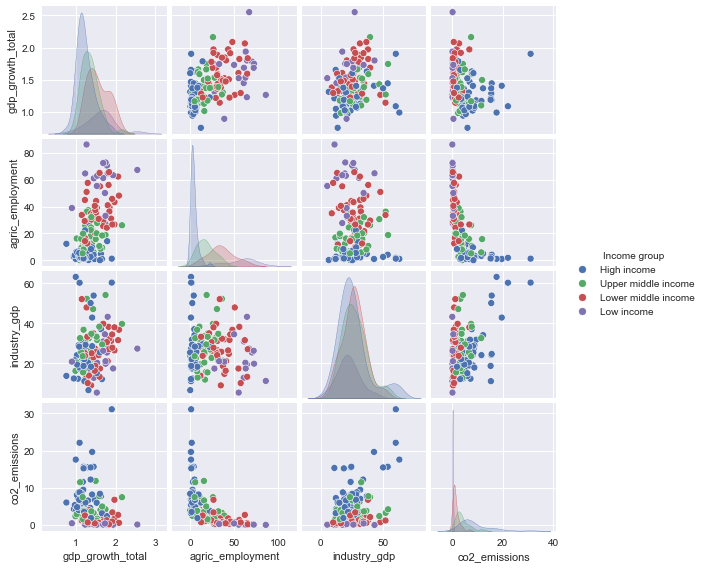

In [60]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_unsupervised[['gdp_growth_total', 'Income group',#'inflation_pp',
                               'agric_employment',
                               'industry_gdp','co2_emissions'
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order, size=2)

## Anomaly/outlier detection:

In this section, we attempt to find countries with outlying observations, and try to identify whether they are such because of remarkable economic conditions, due to major outlier events - crisis, civil war, epidemic, etcetera -, or due to data quality issues

We attempt four outlier detection algorithms:
* **One-class SVM:** adaptation of support vector machine, attempting to create maximum separation between points and origin, and labeling the anomalous observations
* **Local outlier factor:** K-nearest neighbors (KNN) based outlier detection algorithm
* **Isolation forest:** decision rule-based technique with random forest implementation, defines outliers as observations with shorter-than-average path lengths (in the decision tree)
* **Gaussian mixture model:** a probability-based approach for assessing outliers

For this purpose we first scale data and preprocess it in a similar fashion to the subsequent section:

In [44]:
# this code is also executed in the Data Exploration section; no need to run it again if done so
# creating classifications for income groups - provided by the World Bank:

url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications = classifications[['Code', 'Income group']]
classifications.columns = classifications.columns.str.replace('Code', 'ISO3')

In [45]:
pd.set_option("display.max_rows", 20)
wb_out = gdp_df.copy()
wb_out = wb_out.sort_values(by=['Year','ISO3'],ascending='True')

continents = []
for iso3 in wb_out.ISO3:
    try:
        continents = continents + [pycountry_convert.country_alpha2_to_continent_code(pycountry_convert.country_alpha3_to_country_alpha2(iso3))]
    except:
        continents = continents + ['OTHER']
        
wb_out.insert(0, 'continent_code', continents, 'continent_code')
wb_out = wb_out.merge(classifications[['ISO3','Income group']], how='left')
wb_out.columns = wb_out.columns.str.replace('Income group', 'income_group')
wb_out = wb_out[['income_group'] + [col for col in wb_out.columns if col != 'income_group']]
col_group = 'ISO3'
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.ffill().bfill())
col_group = ['income_group','continent_code','Year']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
col_group = ['income_group','continent_code']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
col_group = ['income_group']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
index_target = wb_out.columns.get_loc("gdp_real_gwt_next")
# normalize data except for booleans:
for df in [wb_out]:
    df.iloc[:,index_target:] = StandardScaler().fit_transform(df.iloc[:,index_target:])




x_out = wb_out.iloc[:,(index_target):]
y_out = wb_out.iloc[:,index_target]

### One-class SVM:

In [46]:
oc_svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
oc_svm.fit(x_out)
pred = oc_svm.predict(x_out)
index_svm_out = np.where(pred==-1)
index_svm_out = index_svm_out[0].tolist()
values = x_out.iloc[index_svm_out,:]

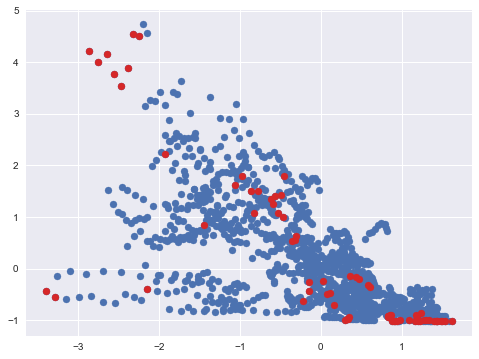

In [47]:
# for visualization, choose whichever covariates you prefer

plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Local Outlier Factor (LOF):

In [48]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = clf.fit_predict(x_out)
X_scores = clf.negative_outlier_factor_

In [49]:
X_scores[X_scores<-np.quantile(X_scores, 0.05)]

array([-1.49203315, -1.04789541, -1.36267203, ..., -1.19612567,
       -1.15448401, -1.06605953])

<AxesSubplot:ylabel='Density'>

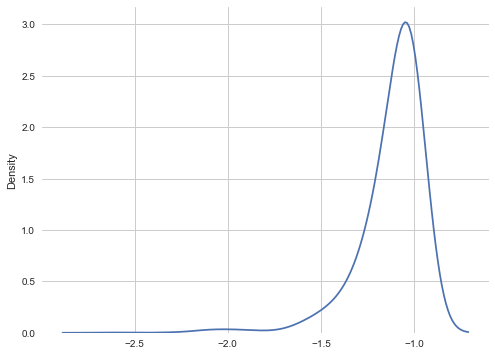

In [50]:
sns.set_style('whitegrid')
sns.kdeplot(X_scores, bw_method=0.5)

In [51]:
x_out.columns

Index(['gdp_real_gwt_next', 'gdp_real_gwt_prev', 'gdp_real_gwt',
       'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt', 'gdp_pp_private',
       'inflation_pp', 'renew_energy', 'unemployment', 'agric_employment',
       'vulnerable_employment', 'imports', 'exports', 'foreign_inv',
       'real_interest_rate', 'cab', 'population', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added', 'homicide'],
      dtype='object')

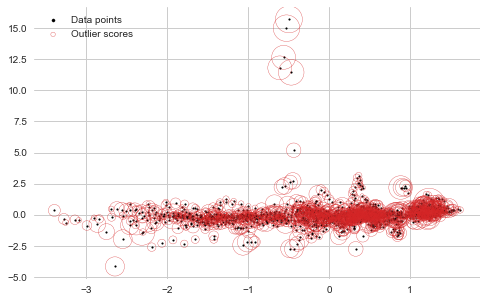

In [52]:
x_axis_col = 'life_expectancy'
y_axis_col = 'cab'

plt.rcParams["figure.figsize"] = (8, 5)
#plt.title("Local Outlier Factor (LOF)")
plt.scatter(x_out.loc[:,x_axis_col], x_out.loc[:,y_axis_col], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    x_out.loc[:,x_axis_col],
    x_out.loc[:,y_axis_col],
    s=1000 * radius,
    edgecolors="tab:red",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
# plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

### Isolation forests:

In [53]:
# fit the model
iso_forest = IsolationForest(max_samples=500, n_estimators=100, contamination=0.05, random_state=777)
predictions = iso_forest.fit_predict(x_out)

In [54]:
outlier_index_if = np.where(predictions==-1)
outlier_index_if = outlier_index_if[0].tolist()
values = x_out.iloc[outlier_index_if]

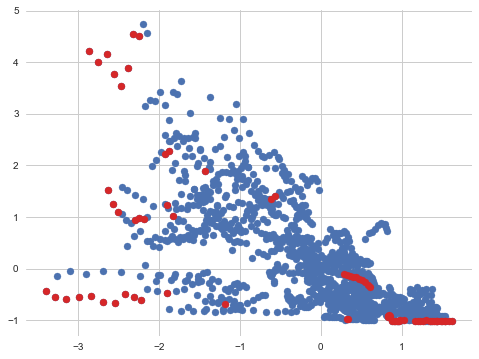

In [55]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Gaussian Mixture:

In [56]:
gausMix = KernelDensity().fit(x_out)

In [57]:
scores = gausMix.score_samples(x_out)
thresh = np.quantile(scores, .05)

In [58]:
outlier_index_gm = np.where(scores <= thresh)
outlier_index_gm = outlier_index_gm[0].tolist()
values = x_out.iloc[outlier_index_gm]

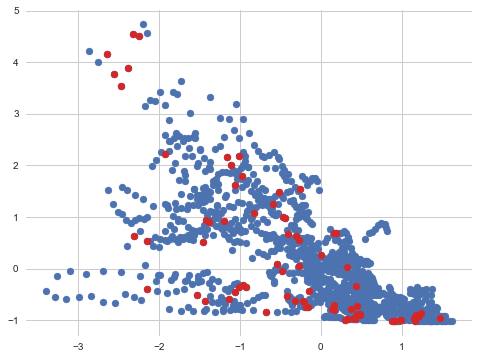

In [59]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Deleting outlier observations/countries:

In [60]:
len(wb_out)

1520

In [61]:
outliers_svm = wb_out.iloc[index_svm_out]
outliers_svm = outliers_svm.groupby(['ISO3']).size().reset_index(name='counts')

In [62]:
index_lof_out = [i for i in range(len(X_scores)) if X_scores[i] < np.quantile(X_scores, 0.05)]
outliers_lof = wb_out.iloc[index_lof_out]
outliers_lof = outliers_lof.groupby(['ISO3']).size().reset_index(name='counts')

In [63]:
outliers_if = wb_out.iloc[outlier_index_if]
outliers_if = outliers_if.groupby(['ISO3']).size().reset_index(name='counts')

In [64]:
outliers_gm = wb_out.iloc[outlier_index_gm]
outliers_gm = outliers_gm.groupby(['ISO3']).size().reset_index(name='counts')

In [65]:
outliers_full = pd.merge(outliers_svm,outliers_lof,how='outer',on='ISO3')
outliers_full = pd.merge(outliers_full,outliers_if,how='outer',on='ISO3')
outliers_full = pd.merge(outliers_full,outliers_gm,how='outer',on='ISO3')
outliers_full.columns = ['ISO3','counts_svm','counts_lof','counts_if','counts_gm']
outliers_full['counts_total'] = outliers_full.fillna(0).sum(axis=1)
pd.set_option("display.max_rows", None)
outliers_full.sum(axis=0)

ISO3            AGOAZEBLRBRNCHNCODHKGINDIRLIRQKIRKWTLSOLUXLVAM...
counts_svm                                                   74.0
counts_lof                                                   76.0
counts_if                                                    76.0
counts_gm                                                    76.0
counts_total                                                302.0
dtype: object

Let us consider potential outliers as all countries that sum 8 or more outlier observations between all 4 algorithms:

In [66]:
outliers_full[outliers_full.counts_total>=8]

,ISO3,counts_svm,counts_lof,counts_if,counts_gm,counts_total
4,CHN,5.0,NaN,10.0,NaN,15.0
6,HKG,6.0,NaN,10.0,NaN,16.0
7,IND,2.0,8.0,NaN,NaN,10.0
8,IRL,2.0,3.0,NaN,3.0,8.0
9,IRQ,1.0,1.0,NaN,6.0,8.0
11,KWT,3.0,NaN,2.0,5.0,10.0
12,LSO,2.0,NaN,10.0,NaN,12.0
17,QAT,5.0,2.0,8.0,5.0,20.0
18,SDN,3.0,1.0,NaN,6.0,10.0
19,SGP,5.0,NaN,6.0,1.0,12.0


In [67]:
threshold_out = 8
for iso in outliers_full[outliers_full.counts_total >= threshold_out].sort_values('ISO3', ascending=True).ISO3.unique():
    try:
        print(iso + ' | ' + pycountry.countries.get(alpha_3=iso).name)
    except:
        print(iso + ' | ' + '------------ NONE')

CHN | China
COG | Congo
HKG | Hong Kong
IND | India
IRL | Ireland
IRQ | Iraq
KWT | Kuwait
LSO | Lesotho
QAT | Qatar
SDN | Sudan
SGP | Singapore
SLE | Sierra Leone
TLS | Timor-Leste
USA | United States


In [68]:
outliers_list = outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()
#for country in outliers_list:
#    print(wb_out[wb_out.ISO3 == country])

In [69]:
outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()

array(['CHN', 'HKG', 'IND', 'IRL', 'IRQ', 'KWT', 'LSO', 'QAT', 'SDN',
       'SGP', 'SLE', 'TLS', 'USA', 'COG'], dtype=object)

In [70]:
listno=-1
listno=listno+1
wb_out[wb_out.ISO3==outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()[listno]].iloc[:,1:]

,continent_code,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,inflation_pp,renew_energy,unemployment,agric_employment,vulnerable_employment,imports,exports,foreign_inv,real_interest_rate,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added,homicide
28,AS,CHN,2009,2.194931,1.668374,1.672661,3.677508,-0.465678,-0.242650,-1.731867,-0.628853,-0.693142,-0.592632,0.601576,0.492098,-0.965968,-0.557406,2.732949,-0.065435,0.451166,8.265635,-0.124995,-0.671144,0.288388,-0.299264,-0.427217,-0.544264,0.795324,-0.102578,-0.192488,0.502520,0.615629,-0.573216,-0.526860,0.242078,1.709152,-0.444074,-0.523185
180,AS,CHN,2010,1.858350,1.601891,2.009103,4.096761,-0.437799,-0.262763,-1.793595,0.278285,-0.734263,-0.626421,0.537888,0.447324,-0.854812,-0.478331,5.325411,-0.909579,0.394283,8.307024,-0.124187,-0.681488,0.324030,-0.288681,-0.463848,-0.520980,0.794704,-0.132081,-0.197244,0.441954,0.633627,-0.573433,-0.514307,0.343273,1.756310,-0.411568,-0.532122
332,AS,CHN,2011,1.335010,1.928340,1.714026,4.513286,-0.410595,-0.183762,-1.756958,0.431072,-0.766597,-0.626421,0.451455,0.408789,-0.831805,-0.498369,6.162408,-0.961263,0.255310,8.354097,-0.123268,-0.635945,0.360778,-0.278098,-0.500478,-0.578070,0.794543,-0.146074,-0.202898,0.384132,0.639077,-0.573069,-0.509383,0.449899,1.759054,-0.385928,-0.541879
484,AS,CHN,2012,1.304738,1.642027,1.255220,4.888988,-0.386977,-0.121077,-1.728214,-0.303816,-0.759919,-0.626421,0.396866,0.381263,-0.881975,-0.533293,5.268116,-0.316852,0.303001,8.412890,-0.122120,-0.541350,0.398264,-0.281626,-0.534057,-0.479770,0.794108,-0.152140,-0.208172,0.327705,0.643226,-0.580186,-0.522670,0.477188,1.662562,-0.354802,-0.547134
636,AS,CHN,2013,1.199149,1.196848,1.228681,5.289206,-0.361972,-0.105571,-1.700673,-0.325288,-0.762731,-0.634868,0.296786,0.355940,-0.904585,-0.562296,6.412255,-0.294863,0.238558,8.471008,-0.120986,-0.550152,0.436119,-0.281626,-0.564583,-0.469648,0.794118,-0.168344,-0.209706,0.271548,0.644491,-0.579586,-0.525732,0.529560,1.553863,-0.348490,-0.551784
788,AS,CHN,2014,1.079897,1.171097,1.136113,5.701601,-0.336342,-0.113688,-1.646727,-0.470144,-0.745509,-0.626421,0.210353,0.333920,-0.931504,-0.597660,5.886813,-0.195776,0.285094,8.526365,-0.119905,-0.575791,0.473973,-0.285153,-0.592056,-0.398697,0.793577,-0.196745,-0.210532,0.215481,0.644621,-0.581834,-0.521161,0.523924,1.458696,-0.335694,-0.555797
940,AS,CHN,2015,1.020162,1.081278,1.031565,6.121685,-0.310320,-0.065107,-1.581043,-0.602424,-0.737074,-0.626421,0.168956,0.315202,-1.049421,-0.667660,5.297470,-0.217641,0.311227,8.577741,-0.118903,-0.610843,0.510721,-0.302791,-0.619529,-0.358277,0.793263,-0.221074,-0.211009,0.159639,0.644621,-0.591128,-0.526196,0.496080,1.262956,-0.312441,-0.561876
1092,AS,CHN,2016,1.050698,0.979836,0.979197,6.559051,-0.283414,-0.047428,-1.525419,-0.422006,-0.723719,-0.626421,0.128469,0.298687,-1.078139,-0.725118,3.738496,-0.405147,0.248776,8.628667,-0.117908,-0.616871,0.545380,-0.313374,-0.643950,-0.358277,0.792854,-0.252352,-0.211633,0.104022,0.644621,-0.589075,-0.528981,0.490227,1.152998,-0.286464,-0.565837
1244,AS,CHN,2017,0.989456,0.929023,1.005967,7.033088,-0.254538,-0.052142,-1.533574,-0.060562,-0.703686,-0.660209,0.095715,0.282906,-1.055521,-0.721615,3.539059,-0.765524,0.237507,8.682771,-0.116852,-0.593780,0.577335,-0.306319,-0.665318,-0.358277,0.792647,-0.308672,-0.211910,0.048945,0.644621,-0.578284,-0.524016,0.512007,1.176641,-0.259192,-0.570250
1396,AS,CHN,2018,0.741520,0.954998,0.952277,7.525650,-0.224087,-0.026576,-1.534861,-0.154326,-0.683301,-0.677104,0.054319,0.249142,-1.037088,-0.740452,5.133510,-0.673927,0.147765,8.724803,-0.116032,-0.692453,0.606095,-0.299264,-0.686686,-0.358277,0.792634,-0.348564,-0.211929,-0.004692,0.644621,-0.566670,-0.516106,0.560305,1.162277,

In [71]:
pd.set_option("display.max_rows", 20)

### Removing outliers (final):

Countries removed are:
* China, due to data reliability issues
* Sudan, due to the civil war that led to the separation of South Sudan - and issues with the data being mixed between these two nations
* Timor Leste - data quality issues
* Republic of the Congo, due to low data quality

In [72]:
gdp_df_final = gdp_df.copy()[~gdp_df.ISO3.isin(['CHN','SDN','TLS','COG'])]

In [73]:
gdp_df_final.shape

(1480, 37)

In [74]:
# REMOVING outliers from benchmark
merge_fc_1S = merge_fc_1S[~merge_fc_1S.ISO3.isin(['CHN','SDN','TLS','COG'])]
merge_fc_1S = merge_fc_1F[~merge_fc_1F.ISO3.isin(['CHN','SDN','TLS','COG'])]

In [75]:
errors_fc_1S = pd.DataFrame({
    'year_fc': list(range(2010,2020)),
    'mae': [mae_forecast_scaled(merge_fc_1S[merge_fc_1S.year == x].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.year == x].gdp_pc_weo) for x in list(range(2010,2020))],
    'rmse': [rmse_forecast_scaled(merge_fc_1S[merge_fc_1S.year == x].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.year == x].gdp_pc_weo) for x in list(range(2010,2020))]
})

errors_fc_1S

,year_fc,mae,rmse
0,2010,0.705119,0.871596
1,2011,0.529471,0.787101
2,2012,0.601646,1.112825
3,2013,0.537417,0.794166
4,2014,0.636008,0.946595
5,2015,0.548799,1.062829
6,2016,0.540404,0.794844
7,2017,0.604766,0.884252
8,2018,0.563426,0.843549
9,2019,0.508013,0.732896


In [76]:
errors_fc_1F = pd.DataFrame({
    'year_fc': list(range(2010,2020)),
    'mae': [mae_forecast_scaled(merge_fc_1F[merge_fc_1F.year == x].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.year == x].gdp_pc_weo) for x in list(range(2010,2020))],
    'rmse': [rmse_forecast_scaled(merge_fc_1F[merge_fc_1F.year == x].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.year == x].gdp_pc_weo) for x in list(range(2010,2020))]
})

errors_fc_1F

,year_fc,mae,rmse
0,2010,0.692461,0.855682
1,2011,0.543504,0.812245
2,2012,0.568428,1.052009
3,2013,0.555039,0.819130
4,2014,0.638851,0.944352
5,2015,0.563428,1.078623
6,2016,0.534005,0.871116
7,2017,0.614503,0.919650
8,2018,0.568350,0.874158
9,2019,0.475121,0.762992


---------------
## Data imputation

Now we move to actually building the ML models; for this, we first do basic data imputation

Population and total GDP are converted to logarithmic scale

For filling missing values, the following approach is considered:
* First, forward fill then backfill is done per variable, per country
* Second, the median value is considered for income level, continent and year groups, per variable
* Third, the median value is considered for income level and continent groups, per variable
* Finally, the median value is considered for income group, per variable

No further approaches are needed for remaining missing values (KNN imputation, etcetera)

In [2]:
pd.set_option("display.max_rows", 20)
gdp_df_final = gdp_df_final.sort_values(by=['Year','ISO3'],ascending='True')
gdp_df_sorted = gdp_df_final.copy()


url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications

classifications = classifications[['Code', 'Income group']]
classifications.columns = classifications.columns.str.replace('Code', 'ISO3')

continents = []
for iso3 in gdp_df_final.ISO3:
    try:
        continents = continents + [pycountry_convert.country_alpha2_to_continent_code(pycountry_convert.country_alpha3_to_country_alpha2(iso3))]
    except:
        continents = continents + ['OTHER']
        
gdp_df_final.insert(0, 'continent_code', continents, 'continent_code')
gdp_df_final = gdp_df_final.merge(classifications[['ISO3','Income group']], how='left')
gdp_df_final.columns = gdp_df_final.columns.str.replace('Income group', 'income_group')
gdp_df_final = gdp_df_final[['income_group'] + [col for col in gdp_df_final.columns if col != 'income_group']]

In [3]:
gdp_df_final

,income_group,continent_code,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,...,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added,homicide
0,Lower middle income,AF,AGO,2009,4.860000,11.170000,0.860000,6.669734e+10,2962.446816,19.898586,...,6.621197,3.208470,40.966,33.802189,97.916348,2.002031,0.939404,44.056374,9924.653411,NaN
1,Upper middle income,EU,ALB,2009,3.706938,7.500041,3.354289,1.004774e+10,3432.169973,11.109434,...,16.794384,22.226277,48.924,100.000000,11.596078,9.552552,1.441494,24.413778,11723.814356,2.859023
2,Upper middle income,SA,ARG,2009,10.125398,4.057233,-5.918525,5.019171e+11,12398.283581,15.903897,...,5.273623,12.530466,9.309,97.750656,10.165245,3.757182,3.867570,25.284205,22333.508982,6.526231
3,Upper middle income,AS,ARM,2009,2.200000,6.900000,-14.100000,8.330244e+09,2884.339470,12.283726,...,NaN,15.785037,36.460,99.227501,0.090388,44.086066,1.561584,NaN,9247.131053,3.358616
4,High income,NA,ATG,2009,-7.840595,-0.014341,-11.962697,1.336013e+09,15401.968641,19.529683,...,1.491637,9.090909,73.182,98.481277,0.000000,6.144381,16.024348,19.460936,NaN,18.445292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,High income,NA,USA,2018,2.288870,2.255680,2.918857,1.947957e+13,59600.053098,13.978639,...,0.909982,17.243857,17.744,100.000000,13.529994,2.957412,15.222548,18.616777,119877.592227,5.005866
1476,Lower middle income,AS,UZB,2018,5.709632,4.395275,5.354997,1.004274e+11,3047.308384,13.462567,...,26.760780,9.225863,49.522,100.000000,24.939491,7.635485,3.412722,27.760070,5046.868941,1.459529
1477,Lower middle income,OC,VUT,2018,3.241188,6.315604,2.900230,8.370542e+08,2860.012476,16.918390,...,21.219188,1.640689,74.726,61.754513,NaN,NaN,0.717519,10.029572,NaN,NaN
1478,Upper middle income,AF,ZAF,2018,0.113054,1.157947,1.487617,3.583074e+11,6199.891699,19.371610,...,2.275252,9.892094,33.645,84.699997,10.992204,25.610143,7.515679,23.506994,16812.467123,36.399174


In [4]:
pd.set_option("display.max_rows", None)
gdp_df_final.isna().sum(0)

income_group                 0
continent_code               0
ISO3                         0
Year                         0
gdp_real_gwt_next            0
gdp_real_gwt_prev            0
gdp_real_gwt                 0
gdp_real_us_fixed            0
gdp_per_capita               0
gdp_pp_govt                 29
gdp_pp_private              29
inflation_pp                 0
renew_energy                 0
unemployment               423
agric_employment            40
vulnerable_employment       40
imports                     20
exports                     20
foreign_inv                  0
real_interest_rate         396
cab                         12
population                   0
pop_density                  0
pop_growth                   0
life_expectancy             10
death_rate                   7
child_mortality             10
renewable_energy_output    441
agric_land                   0
agff_gdp                     3
arable_land                  0
rural_pop                    0
electric

In [5]:
pd.set_option("display.max_rows", 20)

In [6]:
# gdp_df_final['gdp_per_capita'] = gdp_df_final['gdp_real_us_fixed'] / gdp_df_final['population']
gdp_df_final['log_gdp_real_us_fixed'] = np.log(gdp_df_final['gdp_real_us_fixed'])
gdp_df_final['log_population'] = np.log(gdp_df_final['population'])
gdp_df_final['gdp_per_capita'] = np.exp(gdp_df_final['log_gdp_real_us_fixed'] - gdp_df_final['log_population'])
gdp_df_final = gdp_df_final.drop(columns=['gdp_real_us_fixed','population'], inplace=False)

In [7]:
# for nicely summarizing everything below into one function :)
def data_impute(df):
    col_group = 'ISO3'
    list_cols = train_wb.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.ffill().bfill())
    col_group = ['income_group','continent_code','Year']
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
    col_group = ['income_group','continent_code']
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
    col_group = ['income_group']
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
    index_target = df.columns.get_loc("gdp_real_gwt_next")
    # normalize data except for booleans:
    df.iloc[:,index_target:] = StandardScaler().fit_transform(df.iloc[:,index_target:])
    return df

In [8]:
# imputed data
train_wb = gdp_df_final.copy()

In [9]:
col_group = 'ISO3'
for df in [train_wb]:
    list_cols = train_wb.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.ffill().bfill())

In [10]:
train_wb.isna().sum(0)[train_wb.isna().sum(0)>0].index

Index(['unemployment', 'agric_employment', 'vulnerable_employment',
       'real_interest_rate', 'life_expectancy', 'child_mortality',
       'fuel_exports', 'metal_exports', 'co2_emissions', 'service_value_added',
       'homicide'],
      dtype='object')

In [11]:
col_group = ['income_group','continent_code','Year']
for df in [train_wb]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [12]:
col_group = ['income_group','continent_code']
for df in [train_wb]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [13]:
col_group = ['income_group']
for df in [train_wb]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [14]:
pd.set_option("display.max_rows", None)
train_wb.isna().sum(0)

income_group               0
continent_code             0
ISO3                       0
Year                       0
gdp_real_gwt_next          0
gdp_real_gwt_prev          0
gdp_real_gwt               0
gdp_per_capita             0
gdp_pp_govt                0
gdp_pp_private             0
inflation_pp               0
renew_energy               0
unemployment               0
agric_employment           0
vulnerable_employment      0
imports                    0
exports                    0
foreign_inv                0
real_interest_rate         0
cab                        0
pop_density                0
pop_growth                 0
life_expectancy            0
death_rate                 0
child_mortality            0
renewable_energy_output    0
agric_land                 0
agff_gdp                   0
arable_land                0
rural_pop                  0
electricity_access         0
fuel_exports               0
metal_exports              0
co2_emissions              0
industry_gdp  

In [15]:
pd.set_option("display.max_rows", 20)

It is important to mention that the target variable should also be normalized (reference: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)

In [16]:
index_target = train_wb.columns.get_loc("gdp_real_gwt_next")
# normalize data except for booleans:
for df in [train_wb]:
    df.iloc[:,index_target:] = StandardScaler().fit_transform(df.iloc[:,index_target:])
    
# replacing some lingering missing values via KNN imputation (5NN):
#imputer = KNNImputer()

#for df in [train_wb, test_wb]:
#    imputer.fit(df.iloc[:,index_target:])
#    df.iloc[:,index_target:] = imputer.transform(df.iloc[:,index_target:])

In [17]:
x_train = train_wb.iloc[:,(index_target+1):]
y_train = train_wb.gdp_real_gwt_next

In [18]:
x_train.columns

Index(['gdp_real_gwt_prev', 'gdp_real_gwt', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'renew_energy', 'unemployment',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added', 'homicide',
       'log_gdp_real_us_fixed', 'log_population'],
      dtype='object')

----------------------------------------
## Training models:
### We first define the weights for training models:

Slightly higher weights are assigned to countries with higher total GDP - the log-scale is set; otherwise, disproportionate weights would be caused by the largest economies, rendering smaller ones as insignificant for the training of ML models

In [19]:
# ml_weights = np.log(gdp_df_final.loc[x_train.index.tolist(),'gdp_per_capita'])
ml_weights = gdp_df_final.loc[x_train.index.tolist(),'log_gdp_real_us_fixed']

Text(0.5, 0, 'gdp_real_us_fixed')

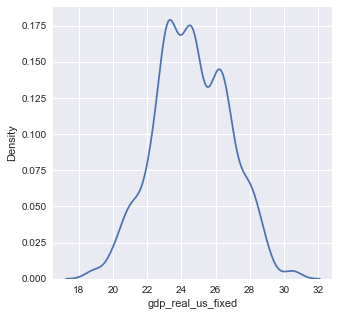

In [20]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(ml_weights)
plt.xlabel('gdp_real_us_fixed')

<AxesSubplot:xlabel='log_gdp_real_us_fixed', ylabel='Density'>

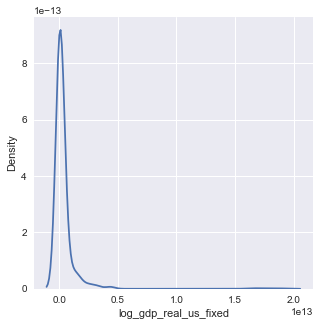

In [21]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(np.exp(ml_weights))

### Defining walking forward CV:

Since we are dealing with longitudinal data, neither a train-test split nor N-fold CV approaches for validating models are suitable - there usually is serial correlation involved in the dataset, plus a knowledge-gaining process over time that is ignored by these two methodologies

What we attempt instead is walk-forward crossvalidation, which consists of the following:
* The first training set is the first period (year) of observations, and the first testing set is the second year
* The second training set includes the first two years, and the second testing set includes the year following (third year)
* Training sets iteratively include the following period, and testing sets iteratively include the period after the last one of the training set
* This is done until the last year is used as validation set, mimicking the information gain process of time series and of longitudinal data

Source: https://robjhyndman.com/hyndsight/tscv/

In [22]:
n_years = int(len(gdp_df_final) / len(gdp_df_final.ISO3.unique())) - 1
tscv = TimeSeriesSplit(n_splits=n_years)

------------------
### Random forest regression:

For this algorithm, random search then gridsearch (with a smaller range) plus time series CV (TSCV) is implemented for hyperparameter tuning

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

In [123]:
# Cross-validation and hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Criterion selection
criterion = ['mse']
# Number of features to consider at every split
max_features = ['auto','sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [128]:
from datetime import datetime
startTime = datetime.now()

rf_regressor = RandomForestRegressor(random_state = 777)
rf_random = RandomizedSearchCV(estimator = rf_regressor,
                               param_distributions = param_grid,
                               n_iter=100, cv = tscv,
                               scoring='neg_mean_absolute_error',
                               n_jobs = -1,
                                random_state=777)
rf_random.fit(x_train, y_train, sample_weight= ml_weights)

print(datetime.now() - startTime)

0:27:56.464798


In [129]:
print('MAE: %.3f' % rf_random.best_score_)
print('Config: %s' % rf_random.best_params_)

MAE: -0.529
Config: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'mse', 'bootstrap': True}


In [130]:
from datetime import datetime
startTime = datetime.now()

# grid (updated iteratively)
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 5)]
criterion = ['mse']
max_features = ['sqrt','log2']
max_depth = [30,40,None] #[int(x) for x in np.linspace(20, 40, num = 3)]
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [True]


# Create the random grid
param_grid2 = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'random_state': [777]}



rf_grid = GridSearchCV(estimator = rf_regressor,
                                param_grid = param_grid2,
                                scoring='neg_mean_absolute_error',
                                cv = tscv,
                                n_jobs = -1)
rf_grid.fit(x_train, y_train, sample_weight= ml_weights)

print(datetime.now() - startTime)

0:09:59.060093


In [131]:
print('MAE: %.3f' % rf_grid.best_score_)
print('Config: %s' % rf_grid.best_params_)

MAE: -0.528
Config: {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 2500, 'random_state': 777}


In [132]:
rf_regressor = RandomForestRegressor(n_estimators= 2500,
                                     min_samples_split= 2,
                                     max_features= 'sqrt',
                                     max_depth= 40,
                                     criterion= 'mse',
                                     bootstrap= True,
                                     random_state = 777)
rf_regressor.fit(x_train, y_train, sample_weight= ml_weights)

RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=2500,
                      random_state=777)

In [133]:
y_model = rf_regressor.predict(x_train)  
mean_absolute_error(y_train, y_model)

0.18922115047045598

In [134]:
cross_val_score(rf_regressor, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5288033108794981

In [135]:
cross_val_score(rf_regressor, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.7915828929023039

<BarContainer object of 34 artists>

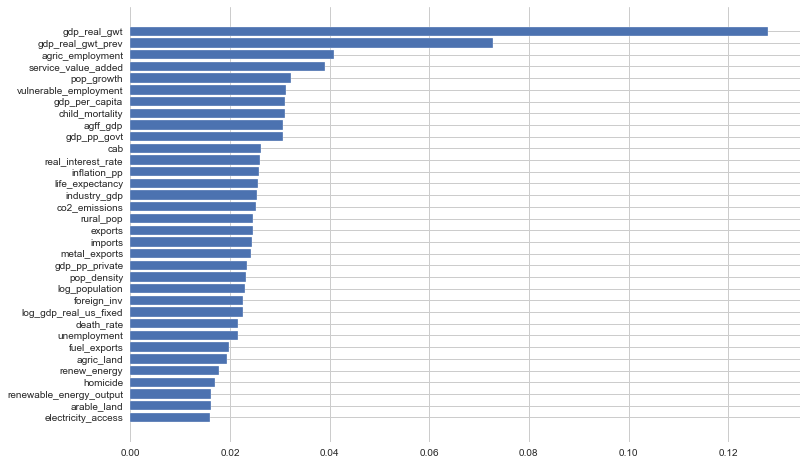

In [136]:
# Plotting feature importance

plt.rcParams['figure.figsize'] = [12, 8]
sorted_idx = rf_regressor.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf_regressor.feature_importances_[sorted_idx])

In [137]:
# plotting permutation importance

perm_importance_rf = permutation_importance(rf_regressor, x_train, y_train)
sorted_idx_rf = perm_importance_rf.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

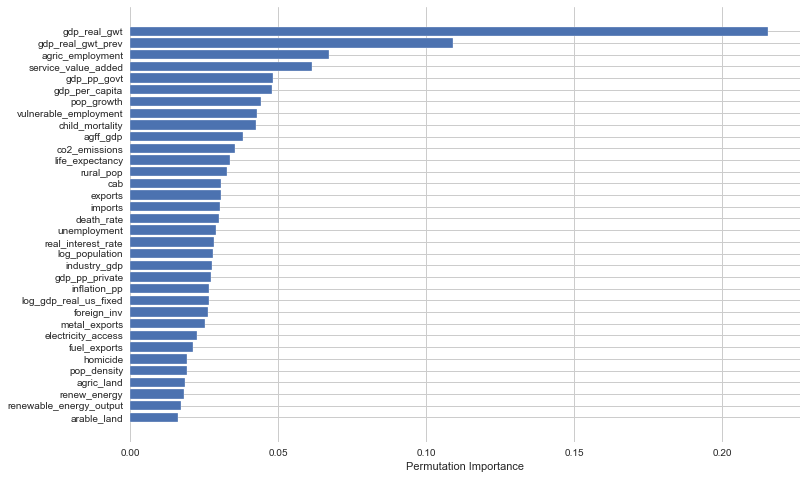

In [138]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.barh(x_train.columns[sorted_idx_rf], perm_importance_rf.importances_mean[sorted_idx_rf])
plt.xlabel("Permutation Importance")

In [140]:
#if you fancy, you can use an alternative visualization via the 'shap' library

import shap
shap.initjs()

In [141]:
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(x_train)

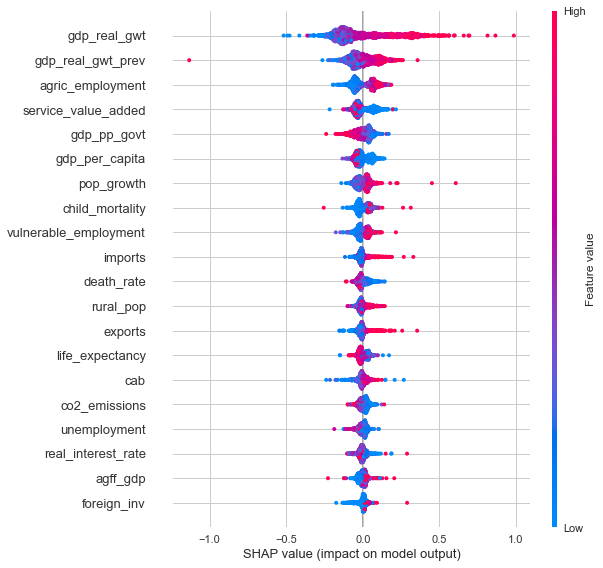

In [142]:
shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns)

### Support Vector Regression (SVR):

Two gridsearchs - with the latter involving a tighter gridsearch - are involved for hyperparameter tuning

In [143]:
svr_regressor = SVR(kernel = 'rbf')

In [144]:
svr_regressor.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [145]:
from datetime import datetime
startTime = datetime.now()

svr_regressor = SVR(kernel = 'sigmoid')

gamma = np.arange(0.0025, 0.01, 0.0025)
tol = np.arange(0.1, 0.15, 0.01)
C_list = np.arange(0.0025, 0.02, 0.0025)
epsilon = np.arange(0.005, 0.02, 0.005)
coef0 = np.arange(0, 0.01, 0.01)


# Create the random grid
param_grid = {'kernel':['sigmoid'],
              'gamma': gamma,
               'tol': tol,
               'C': C_list,
               'epsilon': epsilon,
             'coef0': coef0}

svr_grid = GridSearchCV(estimator = svr_regressor,
                                param_grid = param_grid,
                                scoring='neg_mean_absolute_error',
                                cv = tscv,
                                n_jobs = -1)
svr_grid.fit(x_train, y_train, sample_weight= ml_weights.values)

print(datetime.now() - startTime)

0:01:17.496149


In [146]:
print('MAE: %.3f' % svr_grid.best_score_)
print('Config: %s' % svr_grid.best_params_)

MAE: -0.562
Config: {'C': 0.02, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.0075, 'kernel': 'sigmoid', 'tol': 0.13999999999999999}


In [161]:
from datetime import datetime
startTime = datetime.now()

svr_regressor = SVR(kernel = 'rbf')

gamma = np.arange(0.01, 0.05, 0.005)
tol = np.arange(0.1, 0.15, 0.01)
C_list = np.arange(0.01, 0.07, 0.005)
epsilon = np.arange(0.005, 0.02, 0.005)


# Create the random grid
param_grid = {'kernel':['rbf'],
              'gamma': gamma,
               'tol': tol,
               'C': C_list,
               'epsilon': epsilon}

svr_grid = GridSearchCV(estimator = svr_regressor,
                                param_grid = param_grid,
                                scoring='neg_mean_absolute_error',
                                cv = tscv,
                                n_jobs = -1)
svr_grid.fit(x_train, y_train, sample_weight= ml_weights.values)

print(datetime.now() - startTime)

0:06:44.233313


In [162]:
print('MAE: %.3f' % svr_grid.best_score_)
print('Config: %s' % svr_grid.best_params_)

MAE: -0.545
Config: {'C': 0.019999999999999997, 'epsilon': 0.01, 'gamma': 0.045, 'kernel': 'rbf', 'tol': 0.13}


In [163]:
svr_regressor = SVR(kernel = 'rbf', C=0.02, epsilon=0.01, gamma=0.045, tol=0.13)
svr_regressor.fit(x_train, y_train, sample_weight= ml_weights)

SVR(C=0.02, epsilon=0.01, gamma=0.045, tol=0.13)

In [164]:
y_model = svr_regressor.predict(x_train)  
mean_absolute_error(y_train, y_model)

0.4249145202575622

In [165]:
cross_val_score(svr_regressor, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.6200842689452212

In [166]:
cross_val_score(svr_regressor, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8741513176213158

In [167]:
perm_importance_svr = permutation_importance(svr_regressor, x_train, y_train)

feature_names_svr = x_train.columns
features_svr = np.array(feature_names_svr)

sorted_idx_svr = perm_importance_svr.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

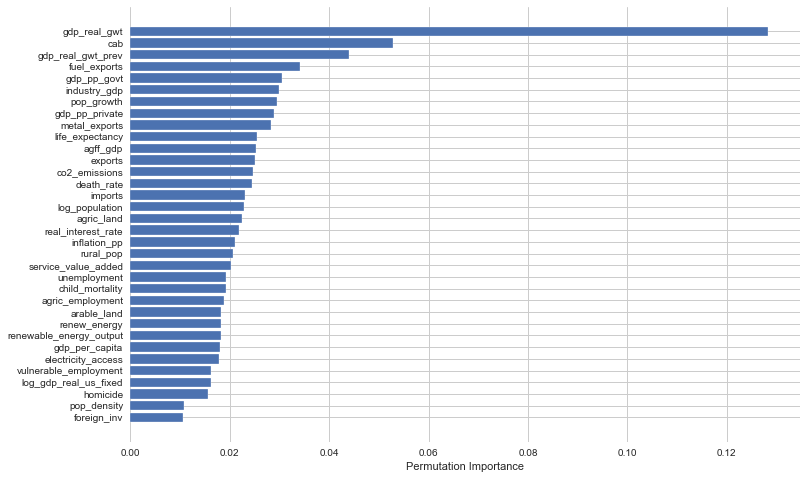

In [168]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.barh(features_svr[sorted_idx_svr], perm_importance_svr.importances_mean[sorted_idx_svr])
plt.xlabel("Permutation Importance")

### K-Nearest Neighbors Regression:

For this algorithm, weighted KNN is considered (with Minkowski distance); the weights to be assigned are the correlation between (next year's) GDP growth and the respective covariates

In [172]:
knn_regression = KNeighborsRegressor()

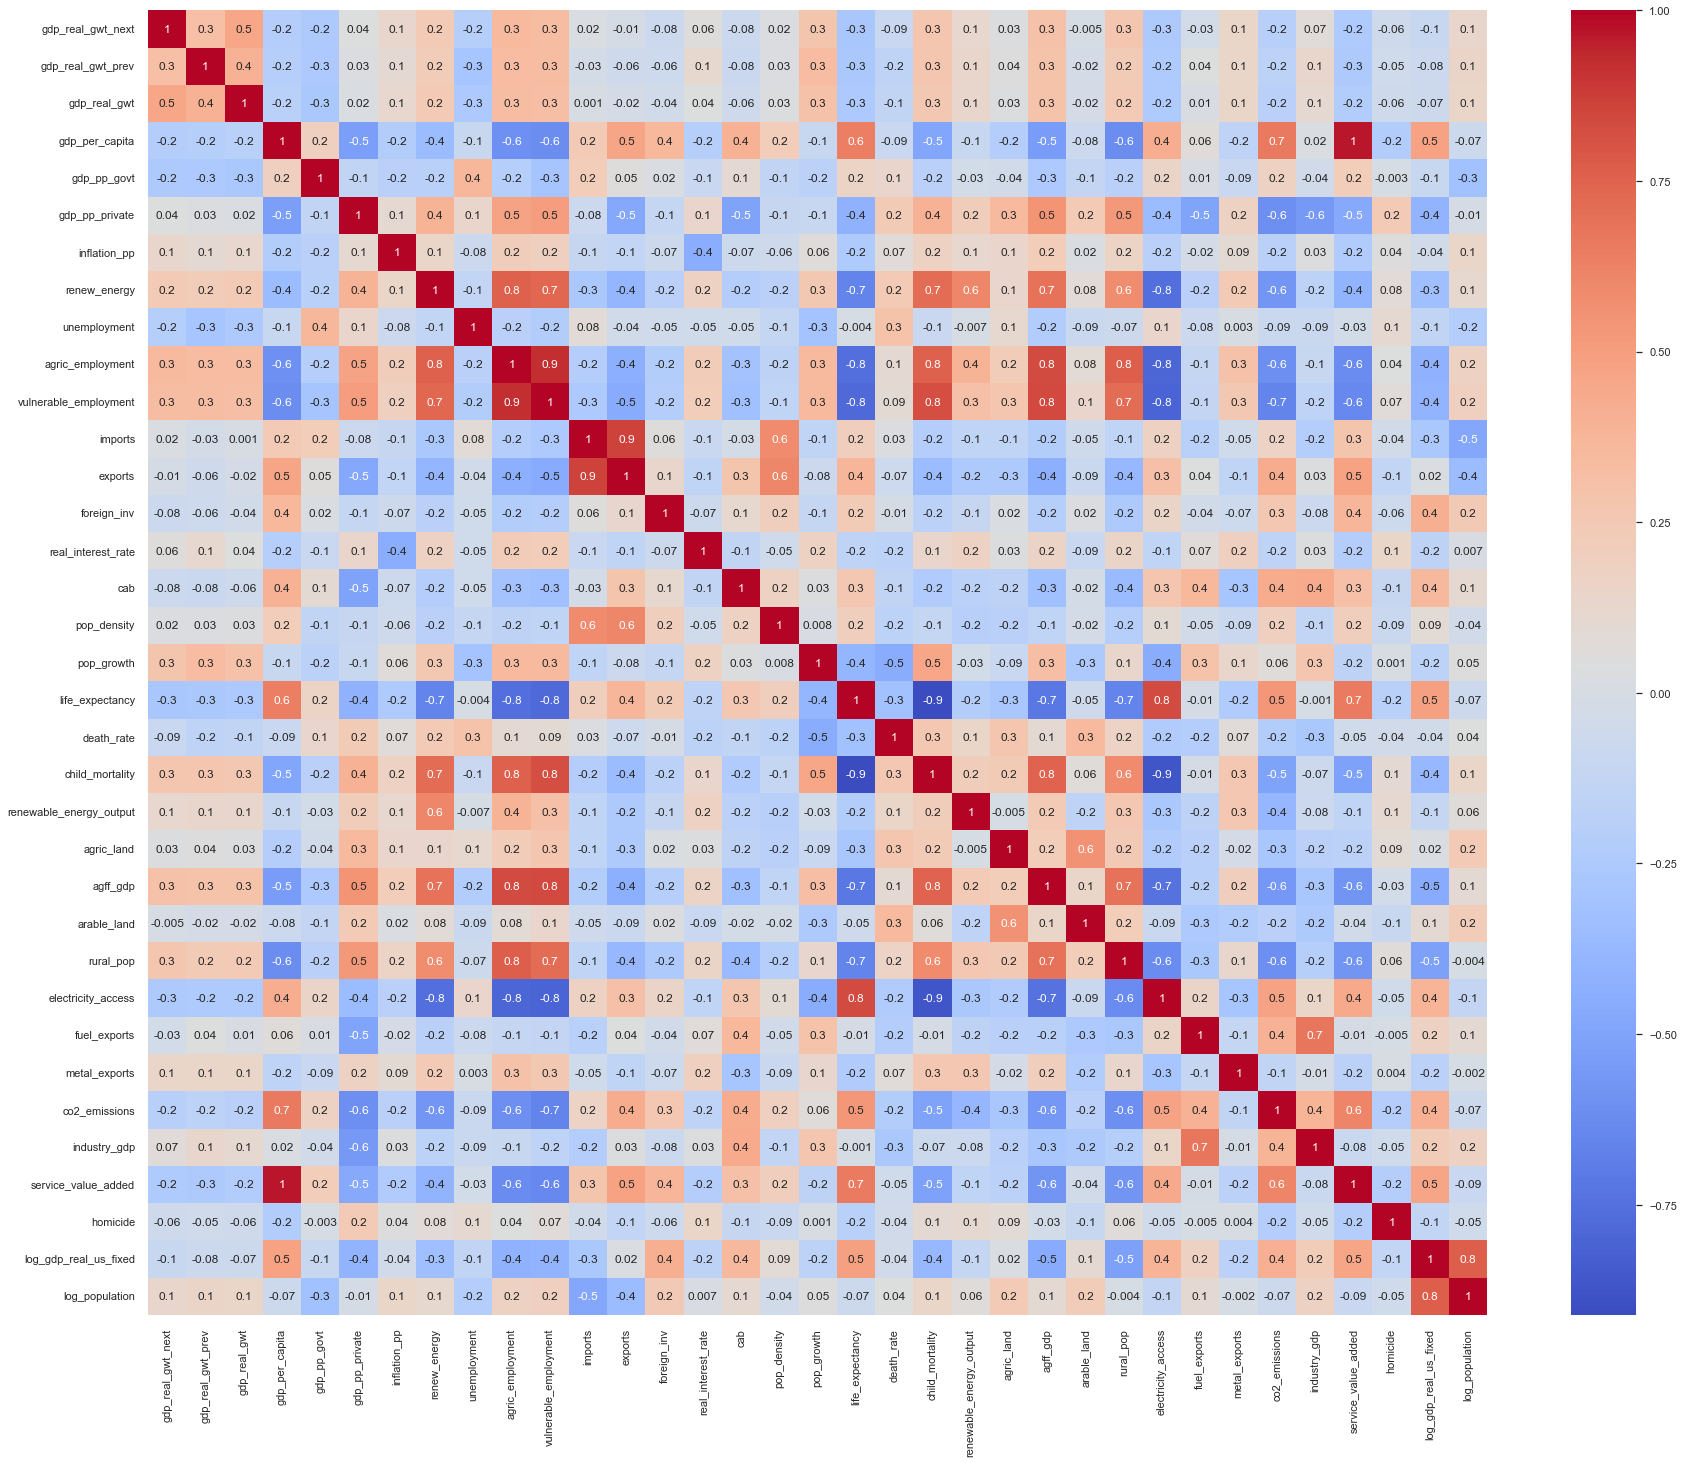

In [173]:
sns.set(rc = {'figure.figsize' : (30, 24)})
corr = pd.concat([y_train, x_train], axis = 1).corr()
corr_map = sns.heatmap(corr, annot = True, 
                       fmt = ".1g", cmap = "coolwarm")

In [176]:
corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)

neighbors = np.arange(1, 50, 1)
scores = []
for k in neighbors:
    clf = KNeighborsRegressor(n_neighbors = k,  weights = 'distance', metric='wminkowski', p=1, metric_params={'w': w_knn})
    clf.fit(x_train, y_train)
    score = cross_val_score(clf, x_train, y_train, cv = tscv, scoring='neg_mean_absolute_error')
    scores.append(score.mean())

Text(0, 0.5, 'MAE')

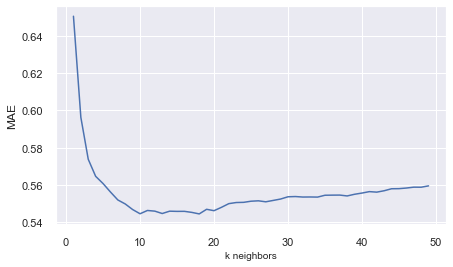

In [177]:
plt.rcParams['figure.figsize'] = [7, 4]
plt.plot(neighbors,[-x for x in scores])
plt.xlabel('k neighbors', fontsize=10)
plt.ylabel('MAE', fontsize=12)

In [178]:
neighbors[np.argmax(scores)]

18

In [179]:
corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)
knn_regression = KNeighborsRegressor(n_neighbors = 18,
                                     weights = 'distance',
                                     metric = 'wminkowski',
                                     metric_params={'w': w_knn},
                                     p=1,
                                     n_jobs = -1)

knn_regression.fit(x_train, y_train)

KNeighborsRegressor(metric='wminkowski',
                    metric_params={'w': gdp_real_gwt_prev        0.317535
gdp_real_gwt             0.456507
gdp_per_capita           0.215660
gdp_pp_govt              0.247870
gdp_pp_private           0.038250
                           ...   
industry_gdp             0.071735
service_value_added      0.241452
homicide                 0.057378
log_gdp_real_us_fixed    0.103995
log_population           0.128590
Name: gdp_real_gwt_next, Length: 34, dtype: float64},
                    n_jobs=-1, n_neighbors=18, p=1, weights='distance')

In [180]:
cross_val_score(knn_regression, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5444686389033463

In [181]:
cross_val_score(knn_regression, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8063570991573834

### Boosted trees regression:

For this algorithm, we implement XGBoost

As for hyperparameter tuning, Bayesian Optimization is implemented - an algorithm that involves a probabilistic model plsu iterative updating of posterior distributions from the prior

It is suitable for black box models with high computational cost, although decreases its performance exponentially as the dimensionality of hyperparameters increases - just as any other algorithm for tuning hyperparameters

In [182]:
xgb_model = xgb.XGBRegressor(n_jobs = -1, random_state = 777)

In [190]:
# Bayesian optimization

pbounds = {
    'learning_rate': (-4,-1),
    'n_estimators': (500, 2000),
    'max_depth': (10,30),
    'subsample': (0.6, 0.8),  # Change for big datasets
    'colsample_bytree': (0.5, 0.75),  # Change for datasets with lots of features
    'gamma': (0.5, 1.5),
    'reg_lambda': (0,1),
    'reg_alpha': (0,1)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample_bytree,
                        gamma,
                       reg_lambda,
                       reg_alpha):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = xgb.XGBRegressor(
        max_depth=max_depth,
        learning_rate=pow(10,learning_rate),
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    return np.mean(cross_val_score(clf, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error'))

xgb_optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=777,
)

xgb_optimizer.maximize(init_points=20, n_iter=200)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.7492   |  0.5382   |  0.8024   | -3.814    |  19.2     |  1.753e+0 |  0.927    |  0.727    |  0.7537   |
|  2        | -0.7502   |  0.5673   |  1.144    | -3.72     |  11.59    |  1.384e+0 |  0.3433   |  0.9889   |  0.7253   |
|  3        | -0.6736   |  0.6704   |  1.052    | -3.193    |  17.47    |  834.4    |  0.1864   |  0.3906   |  0.6386   |
|  4        | -0.554    |  0.6527   |  1.383    | -2.133    |  15.06    |  769.9    |  0.8164   |  0.2254   |  0.7034   |
|  5        | -0.5507   |  0.6296   |  1.1      | -2.402    |  10.27    |  1.286e+0 |  0.8959   |  0.7699   |  0.6246   |
|  6        | -0.5565   |  0.574    |  1.112    | -1.822    |  19.27    |  1.654e+0 |  0.1916   |  0.5579   |  0.7102   |
|  7        | -0.7611   

In [191]:
xgb_optimizer.max['params']

{'colsample_bytree': 0.5120739489120882,
 'gamma': 0.5952844636667254,
 'learning_rate': -2.653255556491361,
 'max_depth': 17.73220244793113,
 'n_estimators': 1016.0967814820892,
 'reg_alpha': 0.10047550871053534,
 'reg_lambda': 0.06308989230019313,
 'subsample': 0.7472019447132114}

In [192]:
xgb_model = xgb.XGBRegressor(booster='gbtree',
                             colsample_bytree=0.512,
                             gamma=0.6,
                             learning_rate=0.0025,
                             max_depth=18,
                             min_child_weight=1,
                             n_estimators= 1000,
                             reg_alpha=0.1,
                             reg_lambda=0.06,
                             subsample=1,
                             n_jobs = -1, random_state = 777)

xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.512,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.6, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0025, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=18, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=777,
             reg_alpha=0.1, reg_lambda=0.06, ...)

In [193]:
y_model = xgb_model.predict(x_train)  
mean_absolute_error(y_train, y_model)

0.20867562450593163

In [194]:
cross_val_score(xgb_model, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5476250377843133

In [195]:
cross_val_score(xgb_model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8153317923012553

<BarContainer object of 34 artists>

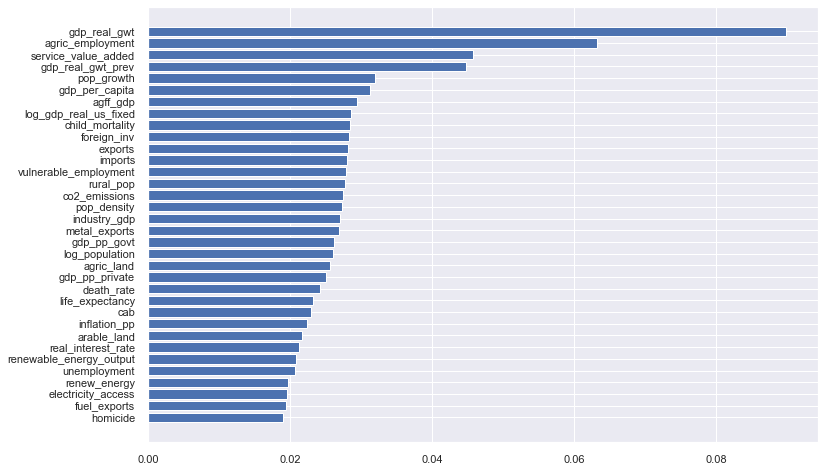

In [196]:
plt.rcParams['figure.figsize'] = [12, 8]
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])

### Artificial Neural Networks (ANN) regression:

In this case, an arbitrary structure with two hidden layers plus two dropout layers is defined; addition of extra layers can be defined for hyperparameter tuning as well, although it is not done in this case for simplicity

Bayesian optimization is performed as well; ideally one would benefit from more iterations, but due to CPU issues I am only illustrating a few

This algorithm can be unstable for some iterations in the case of ANN; further investigation is needed

In [23]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential(neurons1, neurons2, activation1, activation2, learning_rate, batch_size, epochs):
    activationL = ['relu','sigmoid','tanh', 'softsign', 'selu']
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    activation1 = activationL[round(activation1)]
    activation2 = activationL[round(activation2)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        model = Sequential([
            Dense(neurons1, kernel_initializer='normal', activation=activation1),
            Dropout(0.2),
            Dense(neurons2, kernel_initializer='normal', activation=activation2),
            Dropout(0.2),
            Dense(1, kernel_initializer='normal', activation='linear')
        ])
        mse = MeanSquaredError()
        lr = pow(10,learning_rate)
        model.compile(
            loss=mse, 
            optimizer=Adam(learning_rate=lr), 
            metrics=[mse]
        )
        return model
    es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
    nn = KerasRegressor(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    score = cross_val_score(nn, x_train.values, y_train.values,
                            scoring='neg_mean_absolute_error', cv=tscv, fit_params={'callbacks':[es],'sample_weight': ml_weights.values}).mean()
    return score

In [25]:
from datetime import datetime
startTime = datetime.now()

params_nn ={
    'neurons1': (5, 42),
    'neurons2': (5, 42),
    'activation1':(-0.50001,4.49999),
    'activation2':(-0.50001,4.49999),
    'learning_rate':(-5,-1),
    'batch_size':(20, 200),
    'epochs':(20, 300),
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(build_model_using_sequential, params_nn, random_state=777)
nn_bo.maximize(init_points=15, n_iter=25)

|   iter    |  target   | activa... | activa... | batch_... |  epochs   | learni... | neurons1  | neurons2  |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.6009   |  0.2633   |  1.012    |  31.17    |  148.8    | -1.659    |  39.3     |  31.9     |
|  2        | -0.7106   |  3.342    |  0.846    |  135.9    |  46.14    | -4.681    |  26.82    |  17.7     |
|  3        | -0.6272   |  4.444    |  2.632    |  142.7    |  174.6    | -3.925    |  18.81    |  13.25    |
|  4        | -0.6037   |  0.4322   |  1.453    |  54.77    |  191.1    | -1.469    |  28.03    |  14.37    |
|  5        | -0.6027   |  0.3996   |  3.582    |  60.57    |  164.7    | -2.926    |  27.21    |  24.71    |
|  6        | -0.6616   | -0.4335   |  2.12     |  181.3    |  235.6    | -4.509    |  15.95    |  27.64    |
|  7        | -0.5944   |  3.131    |  1.817    |  158.4    |  73.66    | -2.769    |  25.38    |  22.47    |
|  8      

In [26]:
print(datetime.now() - startTime)

3:14:01.732430


In [ ]:
nn_bo.max['params']

In [23]:
hidden_units1 = 22
hidden_units2 = 9
learning_rate = 0.0005
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='tanh'),
        Dropout(0.2, seed=777),
        Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
        Dropout(0.2, seed=777),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    mse = MeanSquaredError()
    model.compile(loss=mse, optimizer=Adam(learning_rate=learning_rate), metrics=[mse])
    return model

In [27]:
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
ann_model = KerasRegressor(build_fn=build_model_using_sequential, epochs=120, batch_size=32, verbose=0)
ann_model.fit(np.asarray(x_train), np.asarray(y_train), verbose=0, callbacks=[es])

In [28]:
cross_val_score(ann_model, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5826784079095734

In [29]:
cross_val_score(ann_model, x_train.values, y_train.values, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8337342499734075

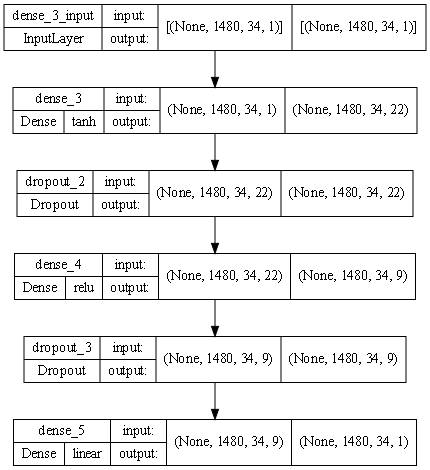

In [25]:
# displaying the structure of the neural network

shape_width, shape_height = x_train.shape[0], x_train.shape[1]
input_shape = (shape_width, shape_height, 1)

mse = MeanSquaredError()
ann_plot = Sequential()
ann_plot.add(Dense(hidden_units1, kernel_initializer='normal', activation='tanh', input_shape=input_shape))
ann_plot.add(Dropout(0.2, seed=777))
ann_plot.add(Dense(hidden_units2, kernel_initializer='normal', activation='relu'))
ann_plot.add(Dropout(0.2, seed=123))
ann_plot.add(Dense(1, activation='linear'))
ann_plot.compile(loss=mse, optimizer=Adamax(lr=0.005), metrics=[mse])

plot_model(ann_plot, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=72, to_file='C://Users/ncozz/Documents/--- KUL/Thesis/pics/neural_network.png') #rankdir='LR'

In [26]:
ann_plot.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1480, 34, 22)      44        
                                                                 
 dropout_2 (Dropout)         (None, 1480, 34, 22)      0         
                                                                 
 dense_4 (Dense)             (None, 1480, 34, 9)       207       
                                                                 
 dropout_3 (Dropout)         (None, 1480, 34, 9)       0         
                                                                 
 dense_5 (Dense)             (None, 1480, 34, 1)       10        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## Forecast combination

Research shows benefit in performing forecast combination for prediction of GDP growth

Following weights are evaluated:
* Equal weights
* Inverse MAE weights
* Inverse MSE weights
* LS weights (explained later)

In [30]:
# TRAINING MODELS AGAIN (not necessary of course, just if you're running the script from this point):

rf_regressor = RandomForestRegressor(n_estimators= 2500,
                                     min_samples_split= 2,
                                     max_features= 'sqrt',
                                     max_depth= 40,
                                     criterion= 'mse',
                                     bootstrap= True,
                                     random_state = 777)

xgb_model = xgb.XGBRegressor(booster='gbtree',
                             colsample_bytree=0.512,
                             gamma=0.6,
                             learning_rate=0.0025,
                             max_depth=18,
                             min_child_weight=1,
                             n_estimators= 1000,
                             reg_alpha=0.1,
                             reg_lambda=0.06,
                             subsample=1,
                             n_jobs = -1, random_state = 777)

svr_regressor = SVR(kernel = 'rbf', C=0.02, epsilon=0.01, gamma=0.045, tol=0.13)


corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)
knn_regression = KNeighborsRegressor(n_neighbors = 18,
                                     weights = 'distance',
                                     metric = 'wminkowski',
                                     metric_params={'w': w_knn},
                                     p=1,
                                     n_jobs = -1)

hidden_units1 = 22
hidden_units2 = 9
learning_rate = 0.0005
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='tanh'),
        Dropout(0.2, seed=777),
        Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
        Dropout(0.2, seed=777),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    mse = MeanSquaredError()
    model.compile(loss=mse, optimizer=Adam(learning_rate=learning_rate), metrics=[mse])
    return model
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
ann_model = KerasRegressor(build_fn=build_model_using_sequential, epochs=200, batch_size=128, verbose=0)

In [31]:
def rescaling_y(y_predict, y_input=gdp_df_final.gdp_real_gwt_next):
    scaler_y = StandardScaler()
    scaler_y.fit(np.array(y_input).reshape(-1,1))
    return scaler_y.inverse_transform(y_predict)

In [32]:
# function for combining forecasts
def forecast_list(x_model, list_models=[], index_list = []):
    return pd.DataFrame([x.predict(x_model) for x in list_models], index=index_list)

def forecast_combination(forecast_list, weights):
    w = weights/sum(weights)
    return forecast_list.multiply(w, axis='rows').sum()

# function for combining forecasts
def forecast_fit_predict(x_train, y_train, x_predict, models, weights):
    for model in models:
        if models==ann_model:
            model.fit(np.asarray(x_train), np.asarray(y_train), verbose=0, callbacks=[es])
        else:
            model.fit(x_train.values, y_train.values)
    df_combine = pd.DataFrame([x.predict(x_predict) for x in models], index=np.array(list(range(0,len(models)))))
    return forecast_combination(df_combine, weights)

In [34]:
#ann_model_copy = tf.keras.models.clone_model(ann_model)
list_models_og = [rf_regressor, xgb_model, svr_regressor, knn_regression, ann_model]
# list_models = [rf_regressor_copy, xgb_model_copy, svr_regressor_copy, elasticnet_model_copy, knn_regression_copy, ann_model]
index_list = ['rf_regressor', 'xgb_model','svr_regressor', 'knn_regression', 'ann_model']

In [35]:
for model in list_models_og:
    model.fit(x_train.values, y_train.values)

In [37]:
# individual performance of each ML algorithm (MAE)
# ['rf_regressor', 'xgb_model','svr_regressor', 'knn_regression', 'ann_model']
[-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean() for x in list_models_og]

[0.5288033108794981,
 0.5476250377843133,
 0.6200842689452212,
 0.5444686389033463,
 0.577526362187868]

In [38]:
# individual performance (RMSE)
# ['rf_regressor', 'xgb_model','svr_regressor', 'knn_regression', 'ann_model']
[-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_root_mean_squared_error').mean() for x in list_models_og]

[0.7915828929023039,
 0.8153317923012553,
 0.8741513176213158,
 0.8063570991573834,
 0.8316627422579295]

In [39]:
# weights for combination: first three
w_equal = np.repeat(1,len(list_models_og))
w_inv_mae = np.reciprocal(
    [-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean() for x in list_models_og])
w_inv_mse = np.reciprocal(
    [-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_squared_error').mean() for x in list_models_og])
w_inv_rmse = np.reciprocal(
    [-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_root_mean_squared_error').mean() for x in list_models_og])

In [48]:
n_0 = int(len(gdp_df_final)/int(len(gdp_df_final) / len(gdp_df_final.ISO3.unique())))
n_f = len(gdp_df_final)

In [46]:
# dataframe used for forecast combination evaluation (considers the second year onwards' forecasts)
forecasts_tscv = pd.DataFrame(columns=list(range(n_0,n_f)))
for model in list_models_og:
    y_model = pd.Series(index=forecasts_tscv.columns)
    for train_index, test_index in tscv.split(y_train):
        model.fit(x_train.iloc[train_index,:].values, y_train[train_index].values)
        y_model[test_index] = model.predict(x_train.iloc[test_index,:].values)
    forecasts_tscv = forecasts_tscv.append(y_model, ignore_index=True)
forecasts_tscv.index = index_list
forecasts_tscv

,148,149,150,151,152,153,154,155,156,157,...,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479
rf_regressor,0.455502,0.100519,0.903848,-0.170130,-1.679973,-0.302523,-0.359264,0.896829,0.563057,-0.013573,...,-0.456785,0.245841,0.701412,0.659088,-0.744110,-0.414666,0.340339,-0.084989,-0.665600,0.239472
xgb_model,0.263018,-0.001250,1.079690,-0.078489,-1.880076,-0.336638,-0.385446,0.740970,0.559279,0.297931,...,-0.424161,0.115044,0.686764,0.713332,-0.646137,-0.384191,0.263150,-0.141983,-0.516176,0.322774
svr_regressor,0.316782,0.268847,0.287703,0.275307,0.232644,0.201161,0.158038,0.328560,0.385357,0.189303,...,-0.211448,0.015401,0.618178,0.438020,-0.260818,-0.241487,0.236377,0.138127,-0.287116,0.260631
knn_regression,0.368674,0.450806,0.672942,-0.047103,-0.817036,-0.091413,-0.298437,0.736947,0.705420,-0.308128,...,-0.506551,0.244221,0.754672,0.594869,-0.318917,-0.424882,0.602308,-0.084438,-0.671894,0.214190
ann_model,1.941441,-0.286091,0.396839,-0.941609,-1.315462,-0.427922,-0.543655,1.729397,0.013493,0.081023,...,-0.075273,0.022214,0.621157,0.977886,-0.437024,-0.546045,1.005337,0.083045,-0.342705,0.851019


In [47]:
forecasts_tscv.transpose()

,rf_regressor,xgb_model,svr_regressor,knn_regression,ann_model
148,0.455502,0.263018,0.316782,0.368674,1.941441
149,0.100519,-0.001250,0.268847,0.450806,-0.286091
150,0.903848,1.079690,0.287703,0.672942,0.396839
151,-0.170130,-0.078489,0.275307,-0.047103,-0.941609
152,-1.679973,-1.880076,0.232644,-0.817036,-1.315462
...,...,...,...,...,...
1475,-0.414666,-0.384191,-0.241487,-0.424882,-0.546045
1476,0.340339,0.263150,0.236377,0.602308,1.005337
1477,-0.084989,-0.141983,0.138127,-0.084438,0.083045
1478,-0.665600,-0.516176,-0.287116,-0.671894,-0.342705


#### Performance with equal weights, inverse MAE and inverse MSE:

In [53]:
# MAE and MSE: equal weights
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_equal[[0,2]])))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_equal[[0,2]]))))

0.5484290108421199
0.8218428230520095


In [54]:
# MAE and MSE: inverse MAE weights
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mae[[0,2]])))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mae[[0,2]]))))

0.5449464743508491
0.8188108181103672


In [55]:
# MAE and MSE: inverse MSE weights
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mse[[0,2]])))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mse[[0,2]]))))

0.5444332885862083
0.8183853124522429


#### Performance with least squares wights approach:
This approach consists of assigning weights according to the coefficients of a simple OLS linear regression; any problems of heteroscedasticity, collinearity, etcetera, are ignored - the purpose is to assign weights!

In [68]:
# LS weights with all algorithms
reg_ls = LinearRegression(fit_intercept=True, normalize=False)
reg_ls.fit(forecasts_tscv.transpose(), y_train[n_0:])
w_ls = reg_ls.coef_
reg_ls.coef_

array([ 0.73326542, -0.04850911,  0.052283  ,  0.10051473,  0.06491361])

In [67]:
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv, w_ls)))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv, w_ls))))

0.5274162290785979
0.8114117327132855


In [69]:
# LS weights with all but random forest
reg_ls_nonrf = LinearRegression(fit_intercept=True, normalize=False)
reg_ls_nonrf.fit(forecasts_tscv.transpose().iloc[:,1:], y_train[n_0:])
w_ls_nonrf = reg_ls_nonrf.coef_
reg_ls_nonrf.coef_

array([0.4308225 , 0.02901363, 0.32517458, 0.13901225])

In [63]:
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf)))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf))))

0.5357890106005644
0.8178341486177217


In [72]:
# LS weights with only RF and SVR (research based approach)
reg_ls_rf_svm = LinearRegression(fit_intercept=True, normalize=False)
reg_ls_rf_svm.fit(forecasts_tscv.transpose().iloc[:,[0,2]], y_train[n_0:])
w_ls_rf_svm = reg_ls_rf_svm.coef_
reg_ls_rf_svm.coef_

array([0.79784744, 0.151819  ])

In [73]:
print(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_ls_rf_svm)))
print(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_ls_rf_svm))))

0.5278413038180813
0.8105469984221177


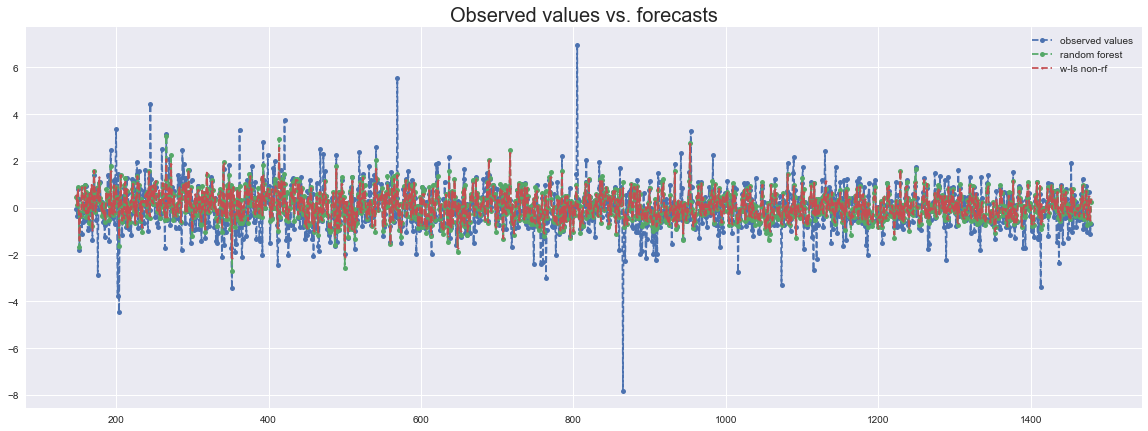

In [86]:
plt.rcParams['figure.figsize'] = [20, 7]
markersize=5
plt.plot(list(range(n_0,n_f)), y_train[n_0:], label = "observed values", linestyle="--",marker="o", markersize=markersize)
plt.plot(list(range(n_0,n_f)), forecasts_tscv.iloc[0,:], label = "random forest",linestyle="--",marker="o", markersize=5)
plt.plot(list(range(n_0,n_f)), forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf), label = "w-ls non-rf",linestyle="--",marker="o", markersize=2)
plt.legend()
plt.title('Observed values vs. forecasts', fontsize=20)
plt.show()

We can observe that the best performing algorithm is the Random Forest, outperforming forecast combination approaches

#### Performance of benchmark:

In [77]:
# spring report: MAE
mae_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=2010].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=2010].gdp_pc_weo)

0.55032023788723

In [78]:
# spring report: RMSE
rmse_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=2010].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=2010].gdp_pc_weo)

0.909389602928758

In [79]:
# fall report: MAE
mae_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=2010].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=2010].gdp_pc_weo)

0.5503925303835867

In [80]:
# fall report: RMSE
rmse_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=2010].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=2010].gdp_pc_weo)

0.9212936788796144

---------------

We observe that the RF model is the best performing one; this, XGBoost and KNN all outperform in both MAE and RMSE

Forecast combination does not present clear advantages of choosing exclusively RF in this project

The RF model presents its advantage in reducing variance - via its ensemble of decision trees and random feature inclusion - and in eliminating most problems induced by collinearity and nonlinearity